# Анализ защищенности систем искусственного интеллекта
# Лабораторная работа №1
# Демонстрация модели состязательности
## Выполнил студент группы ББМО-02-23
## Беляев Степан Константинович

## Импорт библиотек

In [ ]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from project_utils import get_clip_bounds, evaluate_attack, display_attack

ModuleNotFoundError: No module named 'project_models'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Подключение модуля SSL и настройка пропускать проверку SSL сертификата

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Установки

### Устанавливаем рандомное число, в данном случае порядковый номер в списке - 19

In [ ]:
np.random.seed(19)
torch.manual_seed(19)


Проверяем доступность cuda и выбираем устройство

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## Download & Pre-Process Datasets

### MNIST Dataset

In [ ]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean,
                                       mnist_std,
                                       mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=0.0,
        std=np.divide(1.0, mnist_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, mnist_std),
        std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True,
                            download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False,
                            download=True, transform=mnist_tf)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.69MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



### CIFAR-10 Dataset

In [ ]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean,
                                       cifar_std,
                                       cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(
        size=cifar_dim,
        padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, cifar_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, cifar_mean),
        std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True,
                              download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False,
                              download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


## Dataset Loaders

In [ ]:
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## DeepFool Parameters

In [ ]:
deep_batch_size = 10
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 50

deep_args = [deep_batch_size, deep_num_classes,
             deep_overshoot, deep_max_iters]

## MNIST Adversarial Evaluation

# 0.001

## CIFAR-10 Adversarial Evaluation

### Network-In-Network Model

In [ ]:
fgsm_eps = 0.001
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

evaluate_attack('cifar_nin_fgsm_001.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool_001.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-25-680a53dd94a5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 10.12%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 2.58 s
FGSM Time (Per Image) : 258.49 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 196.55 s
DeepFool Time (Per Image) : 19.65 ms


### LeNet Model

In [ ]:
fgsm_eps = 0.001
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

evaluate_attack('cifar_lenet_fgsm_001.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool_001.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-26-ff5158e93e4d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 22.72%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.55 s
FGSM Time (Per Image) : 154.66 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 87.80%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 107.28 s
DeepFool Time (Per Image) : 10.73 ms


## Display Adversarial Examples

### MNIST

#### LeNet Model

<ipython-input-27-1367bbf14ff9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

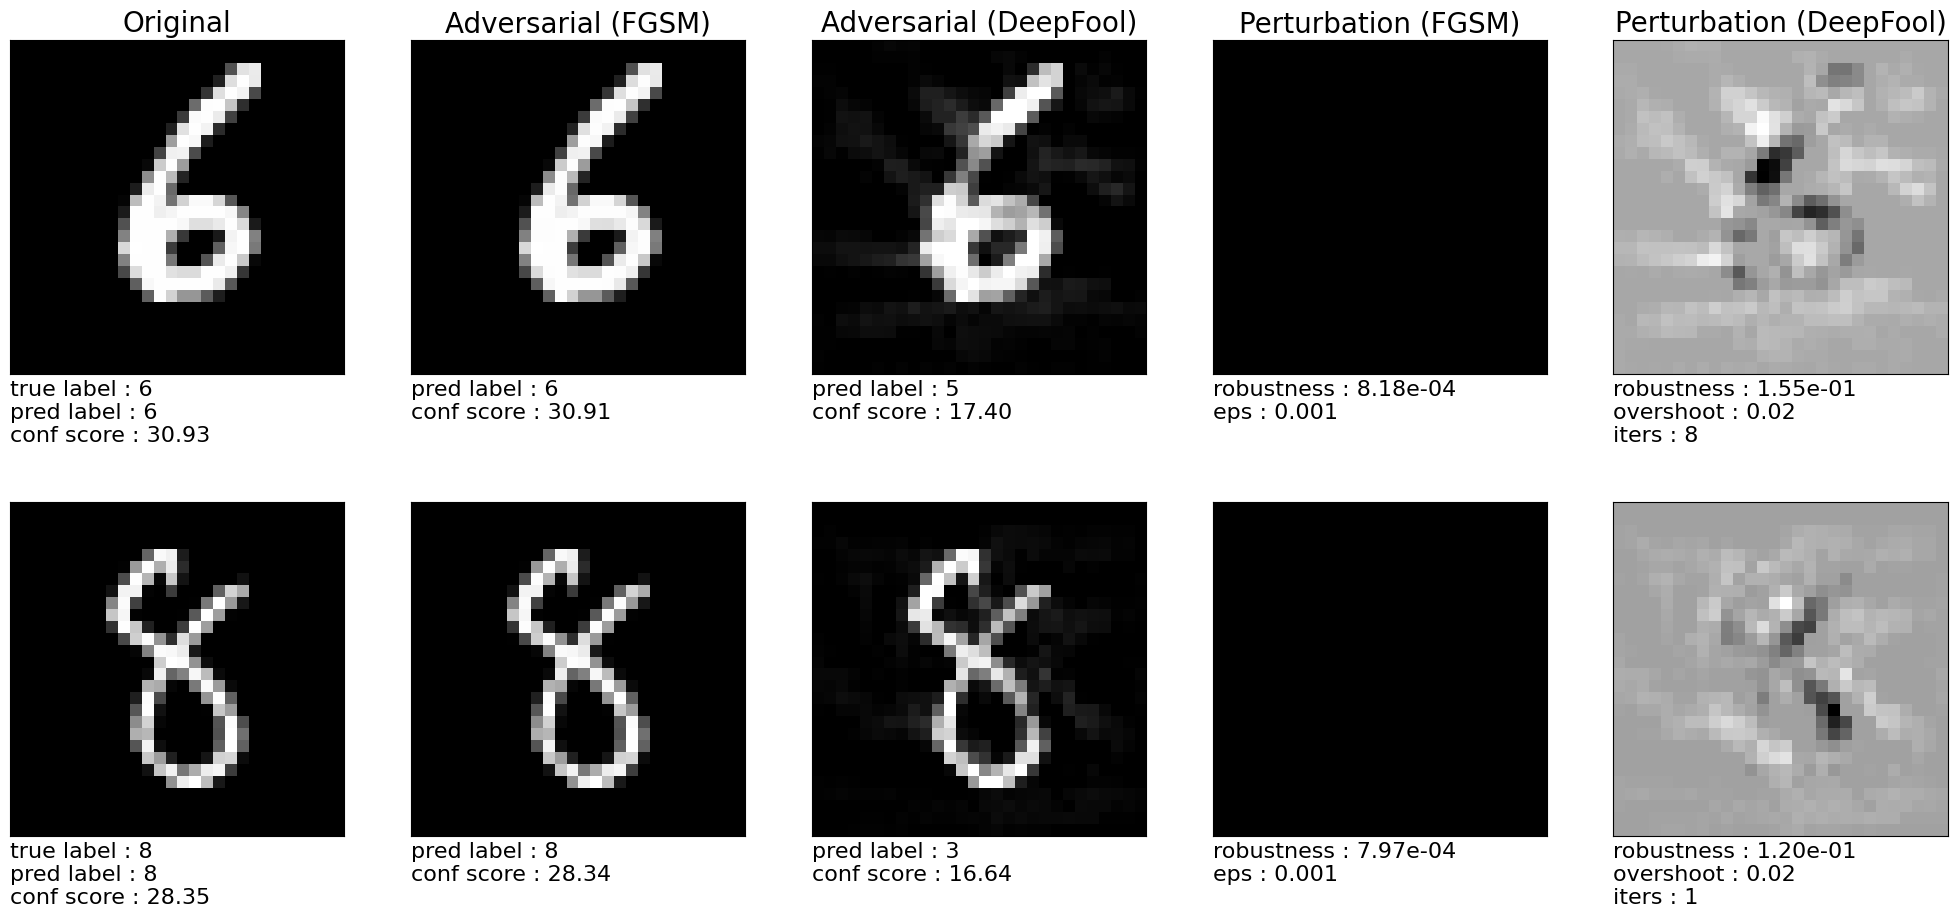

In [ ]:
fgsm_eps = 0.001
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### FC Model

<ipython-input-28-594c65c3cb7e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

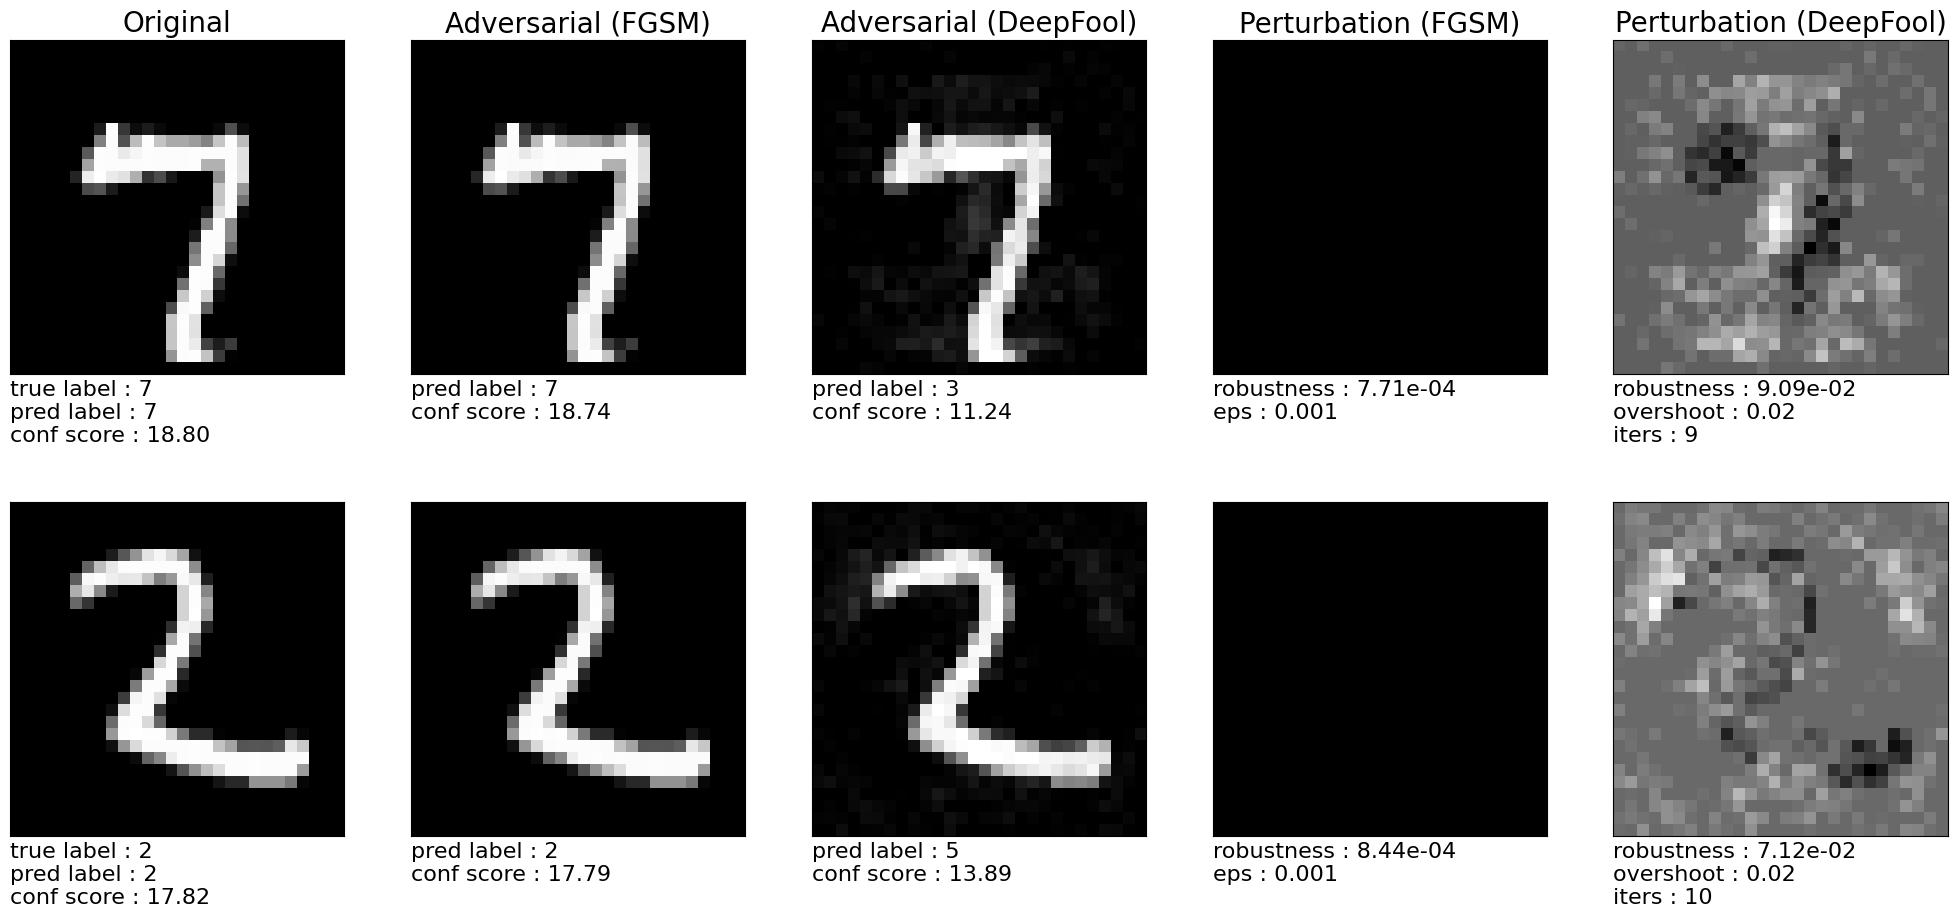

In [ ]:
fgsm_eps = 0.001
model = FC_500_150().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### CIFAR-10

#### Network-In-Network Model

<ipython-input-29-0b81d0c4fd86>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

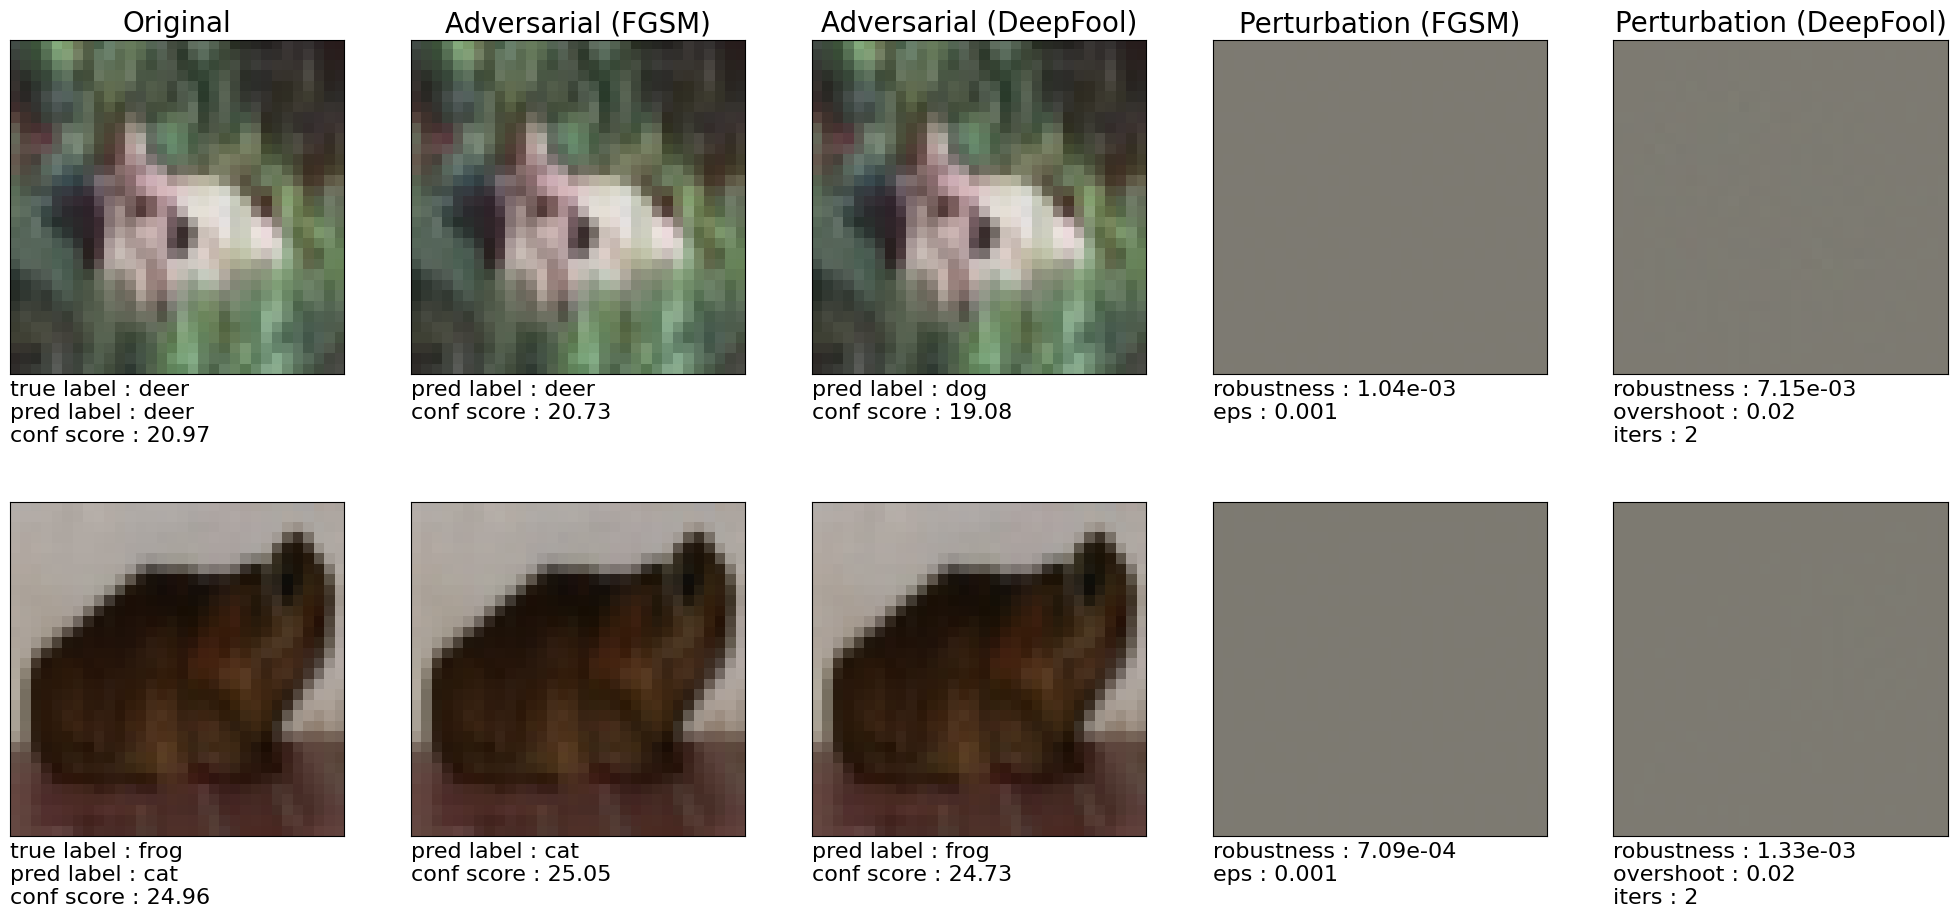

In [ ]:
fgsm_eps = 0.001
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### LeNet Model

<ipython-input-30-3f4d5388b855>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

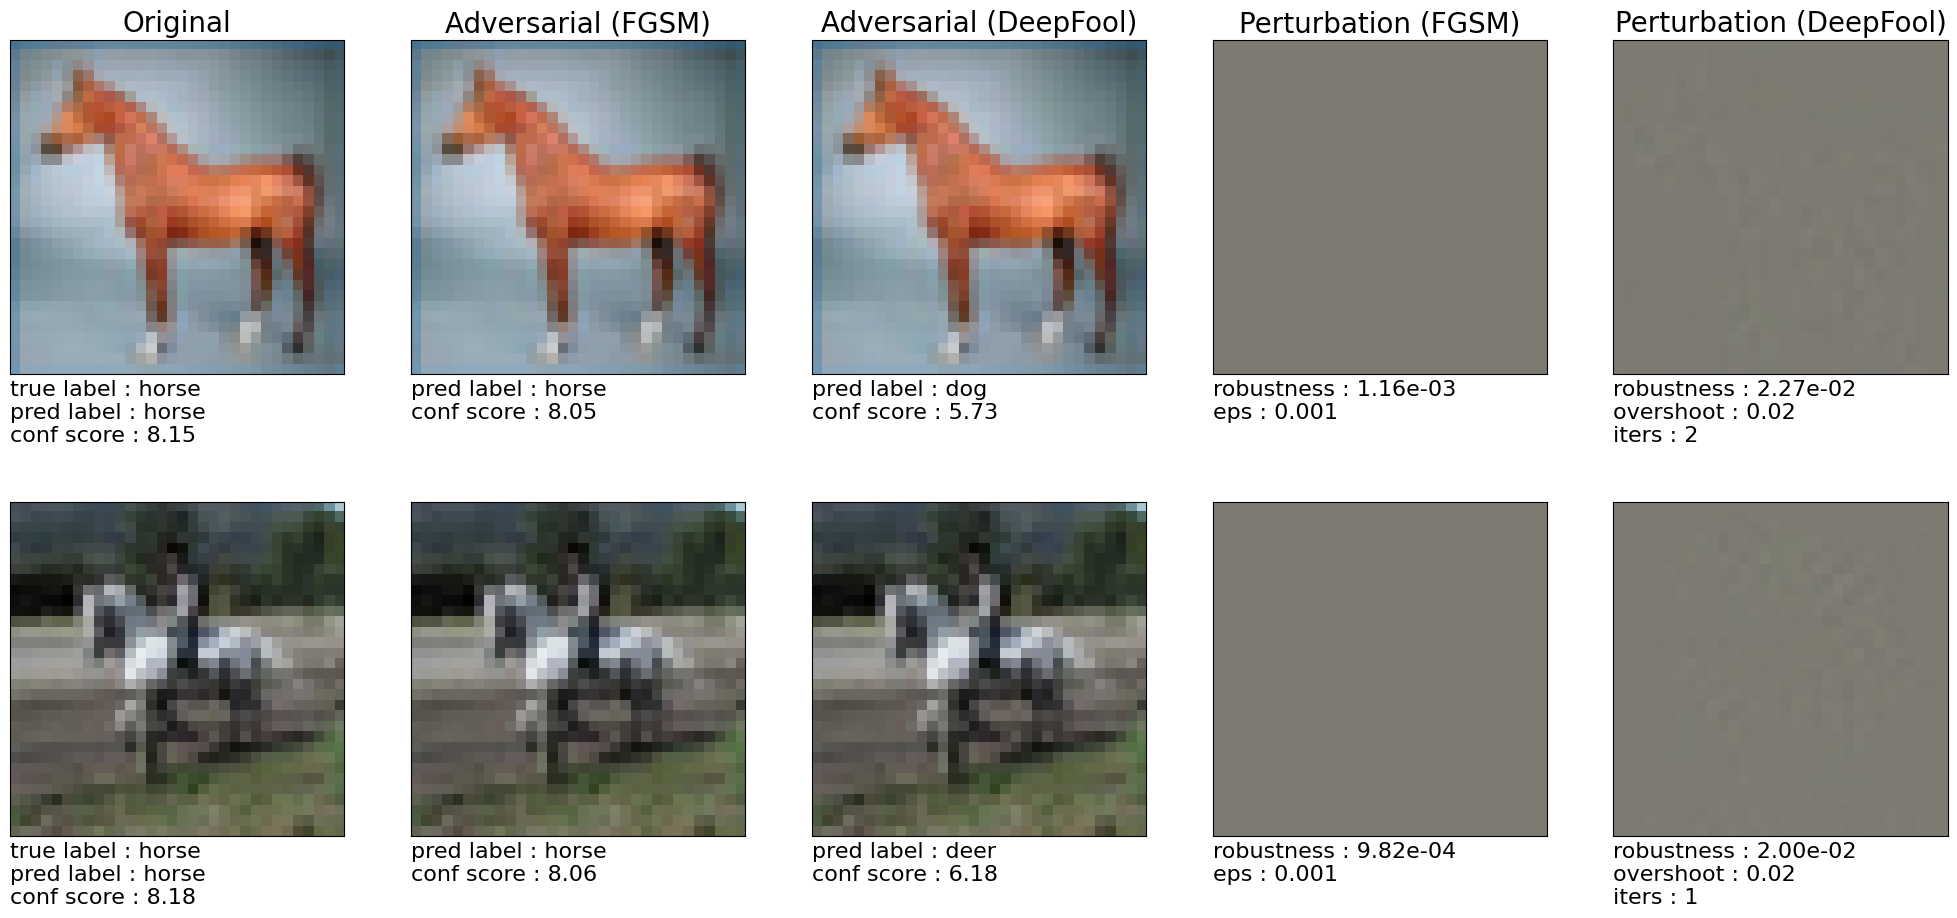

In [ ]:
fgsm_eps = 0.001
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

# 0,02

## CIFAR-10 Adversarial Evaluation

### Network-In-Network Model

In [ ]:
fgsm_eps = 0.02
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

evaluate_attack('cifar_nin_fgsm_02.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool_02.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-31-6189a5402aa7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 30.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.28 s
FGSM Time (Per Image) : 128.08 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 198.26 s
DeepFool Time (Per Image) : 19.83 ms


### LeNet Model

In [ ]:
fgsm_eps = 0.02
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

evaluate_attack('cifar_lenet_fgsm_02.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool_02.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-32-7ea6047e0b59>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 47.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.29 s
FGSM Time (Per Image) : 128.58 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 87.80%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 105.20 s
DeepFool Time (Per Image) : 10.52 ms


## Display Adversarial Examples

### MNIST

#### LeNet Model

<ipython-input-33-6db8f06fbc0f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

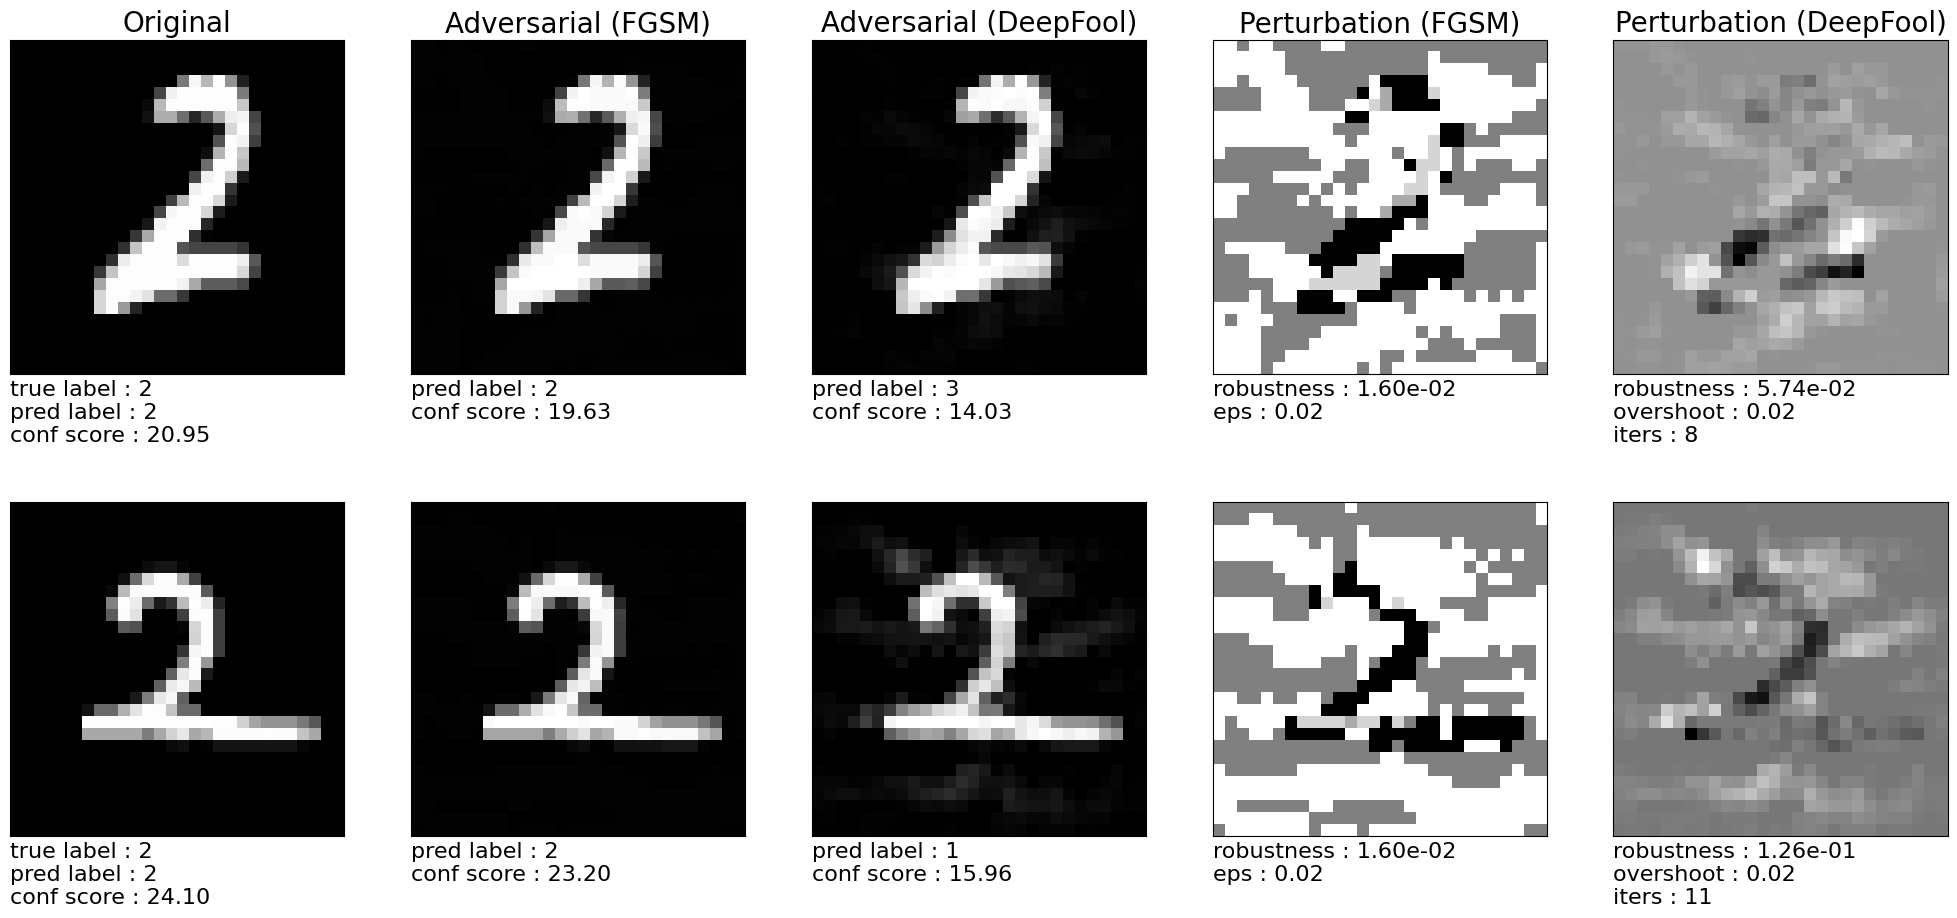

In [ ]:
fgsm_eps = 0.02
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### FC Model

<ipython-input-34-2c8d8e8130ef>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

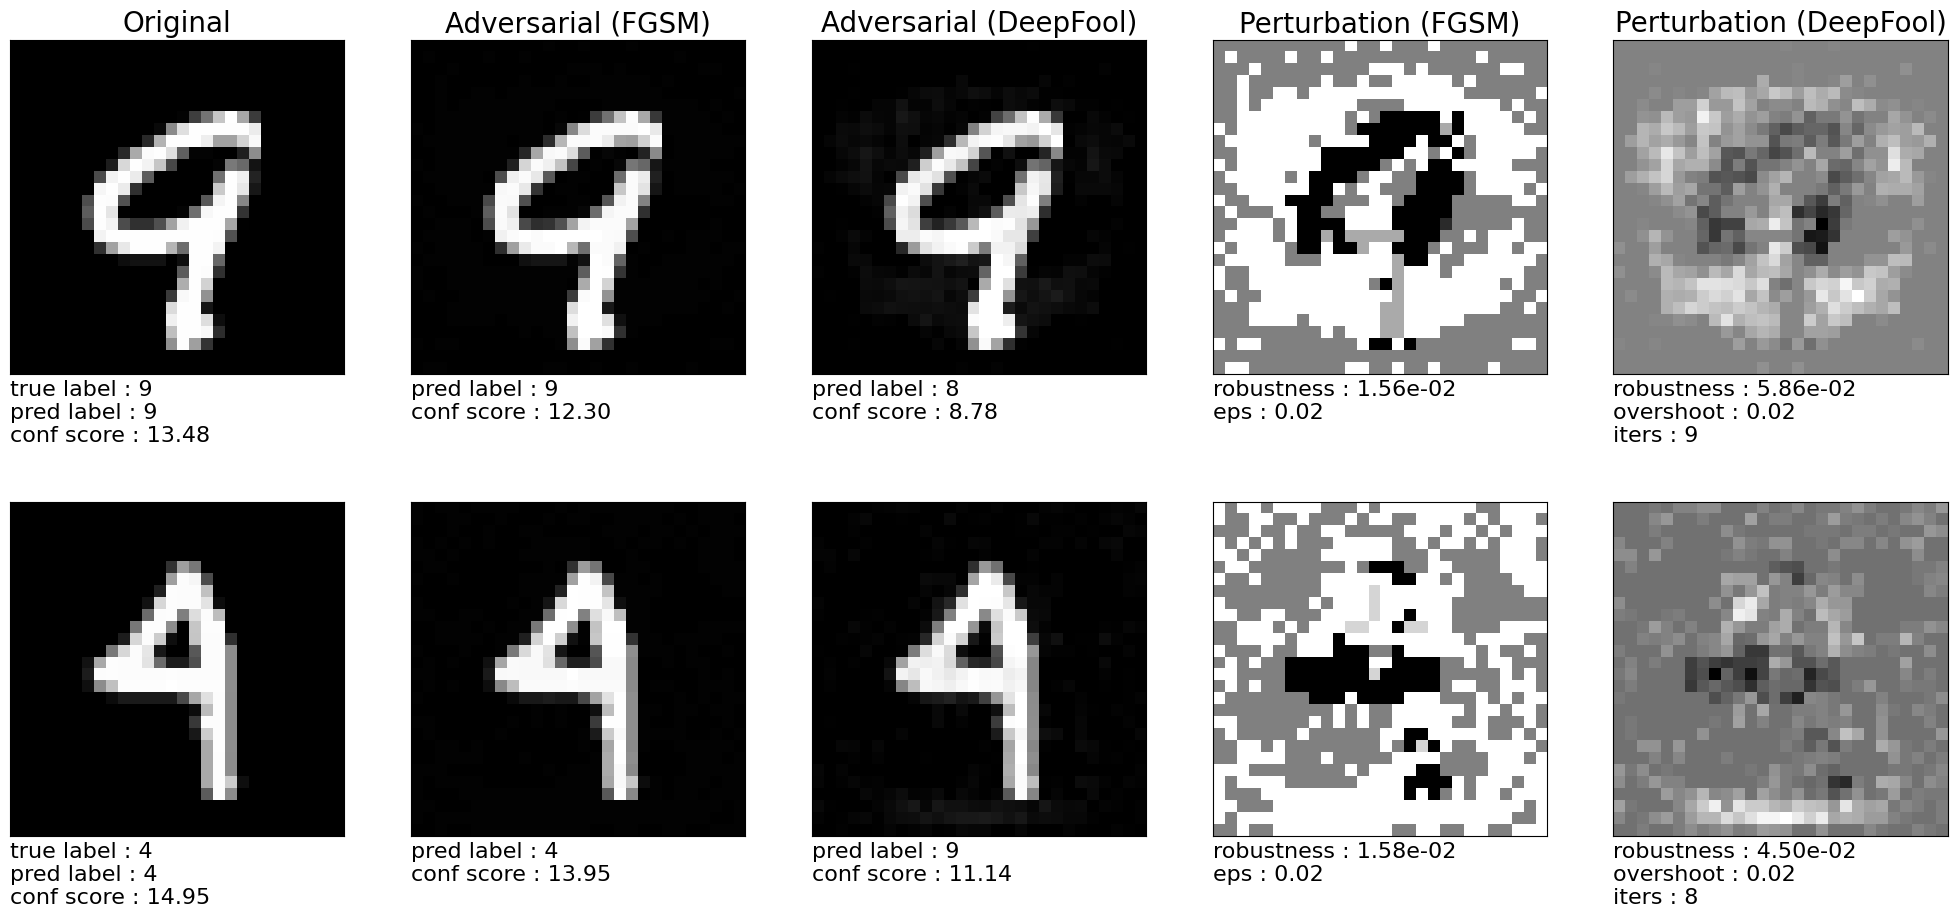

In [ ]:
fgsm_eps = 0.02
model = FC_500_150().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### CIFAR-10

#### Network-In-Network Model

<ipython-input-35-4d8fc3574991>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

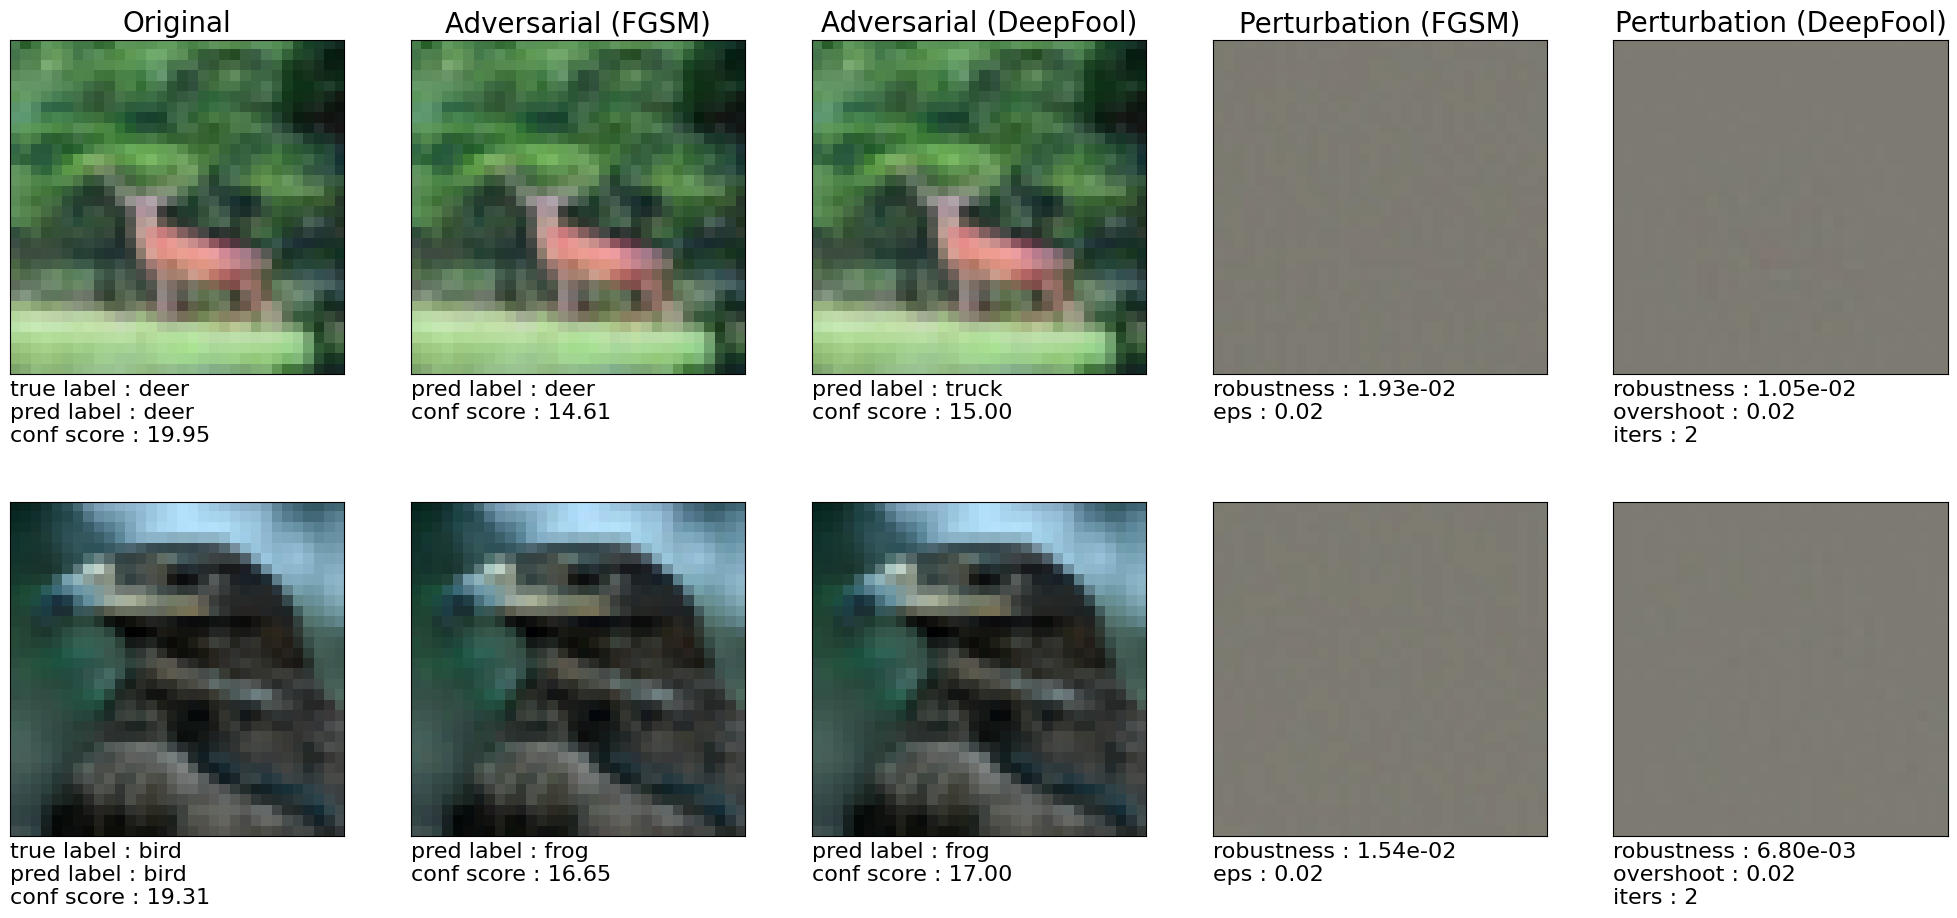

In [ ]:
fgsm_eps = 0.02
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### LeNet Model

<ipython-input-36-68092ffd3990>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

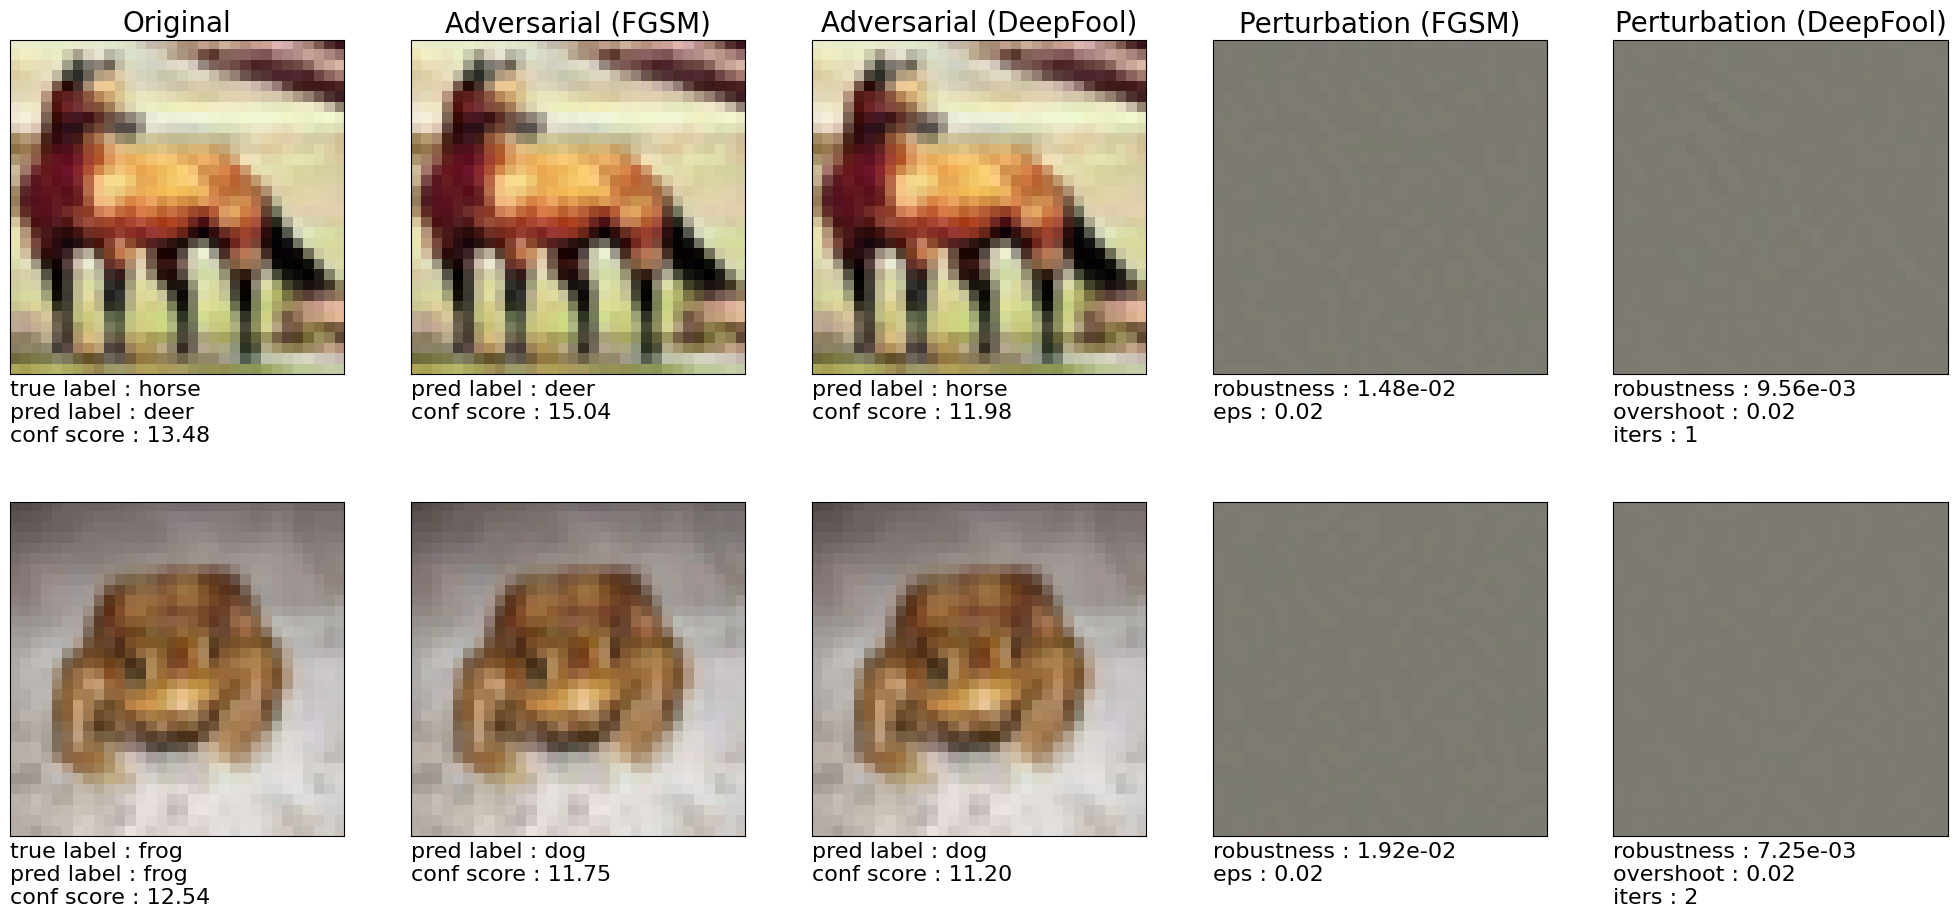

In [ ]:
fgsm_eps = 0.02
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

# 0,5

## CIFAR-10 Adversarial Evaluation

### Network-In-Network Model

In [ ]:
fgsm_eps = 0.5
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

evaluate_attack('cifar_nin_fgsm_5.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool_5.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-37-0ab88b63a29c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.67%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.15 s
FGSM Time (Per Image) : 115.24 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 198.68 s
DeepFool Time (Per Image) : 19.87 ms


### LeNet Model

In [ ]:
fgsm_eps = 0.5
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

evaluate_attack('cifar_lenet_fgsm_5.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool_5.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-38-8c8ce3d5a447>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 95.17%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.43 s
FGSM Time (Per Image) : 143.16 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 87.80%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 105.94 s
DeepFool Time (Per Image) : 10.59 ms


## Display Adversarial Examples

### MNIST

#### LeNet Model

<ipython-input-39-8dc566225ab3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

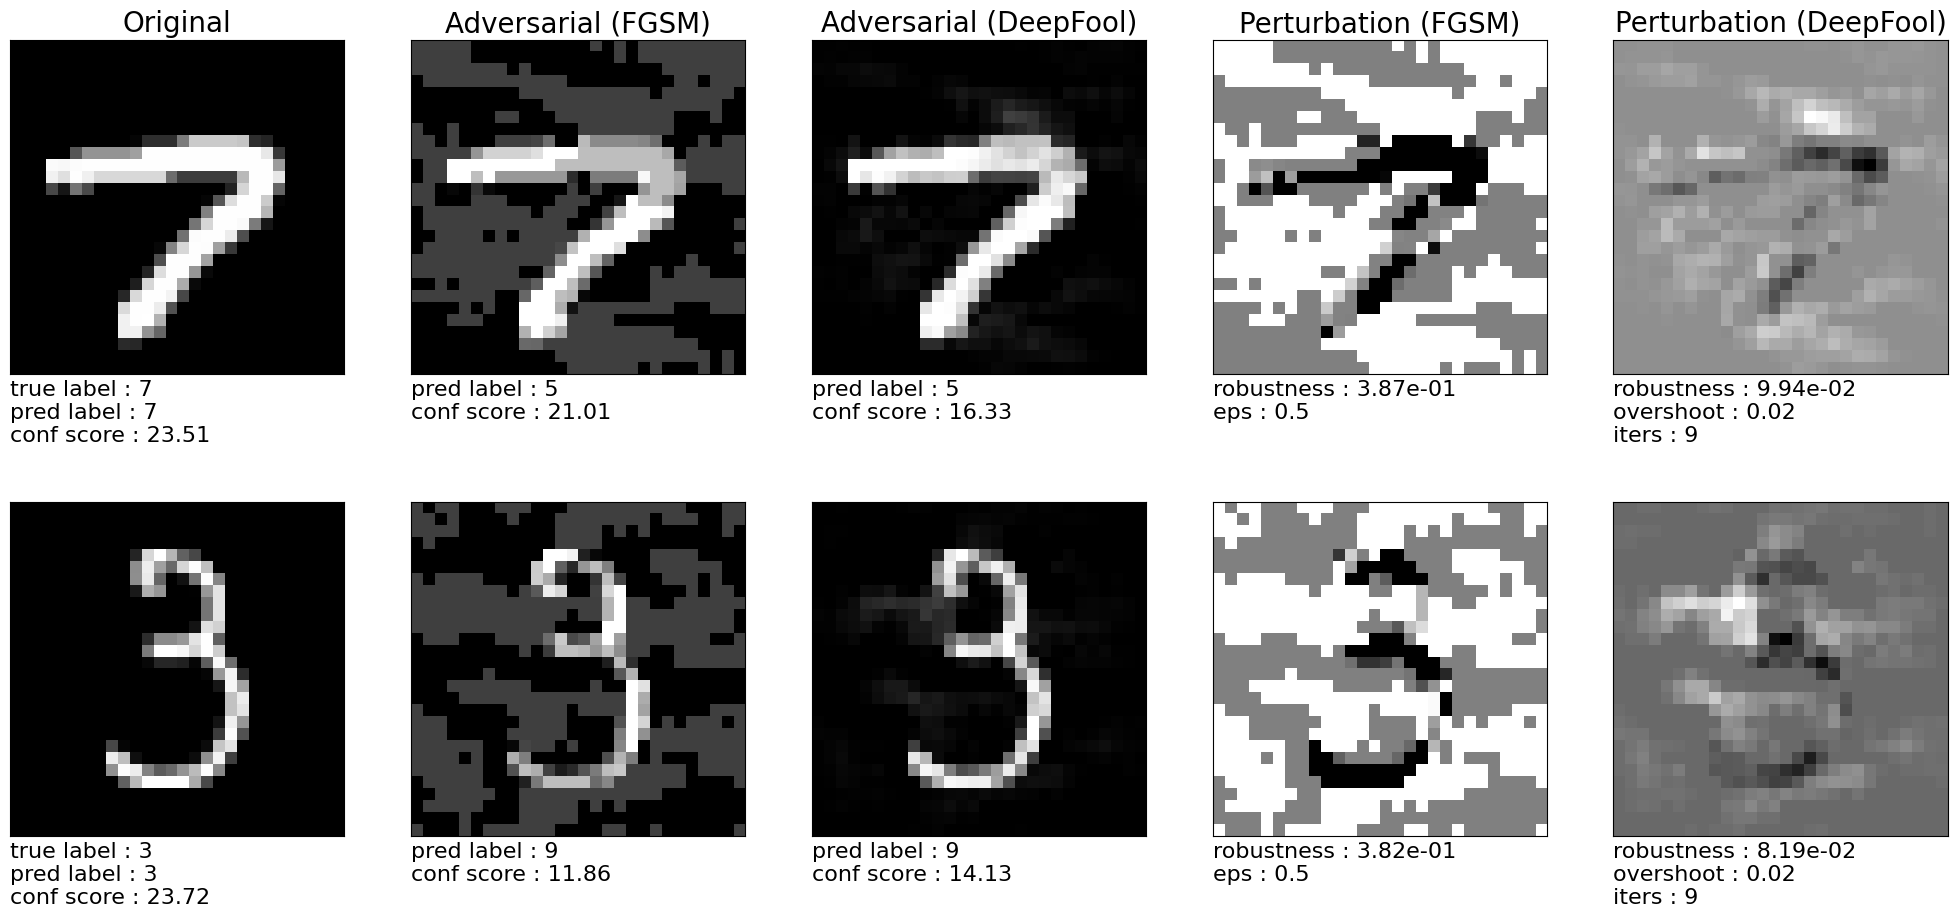

In [ ]:
fgsm_eps = 0.5
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### FC Model

<ipython-input-40-f263ea6c181b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

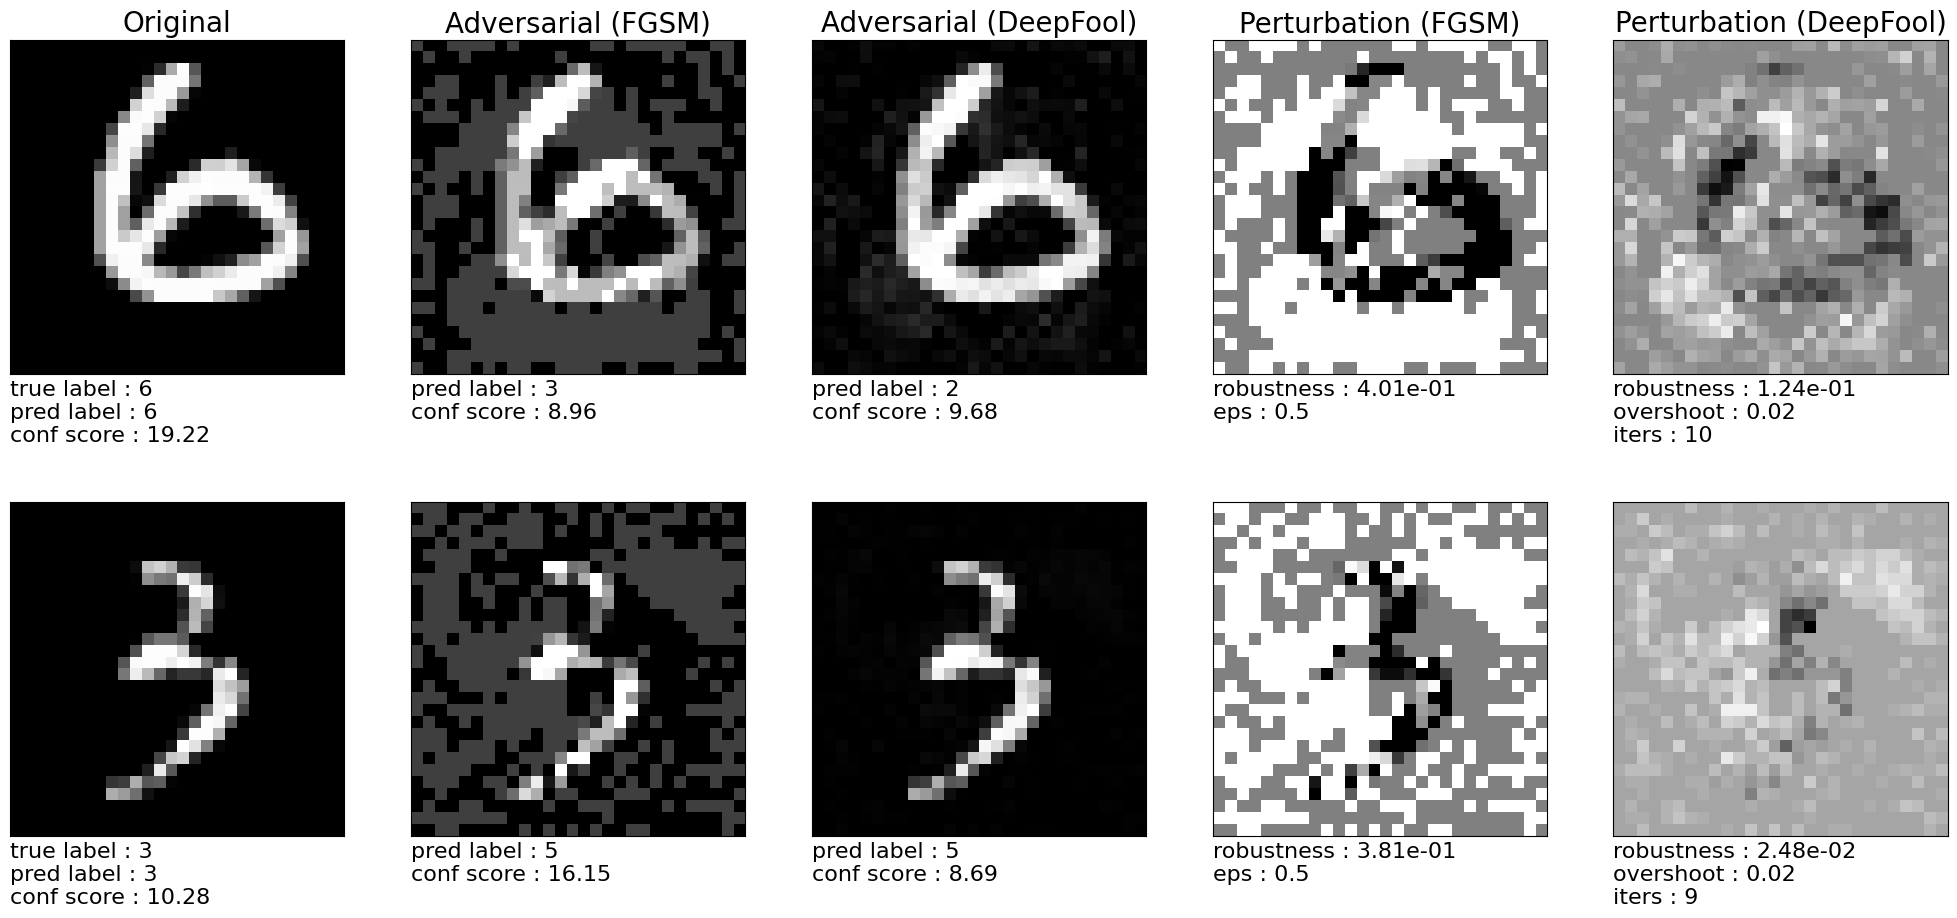

In [ ]:
fgsm_eps = 0.5
model = FC_500_150().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### CIFAR-10

#### Network-In-Network Model

<ipython-input-41-9ba67eac06fb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

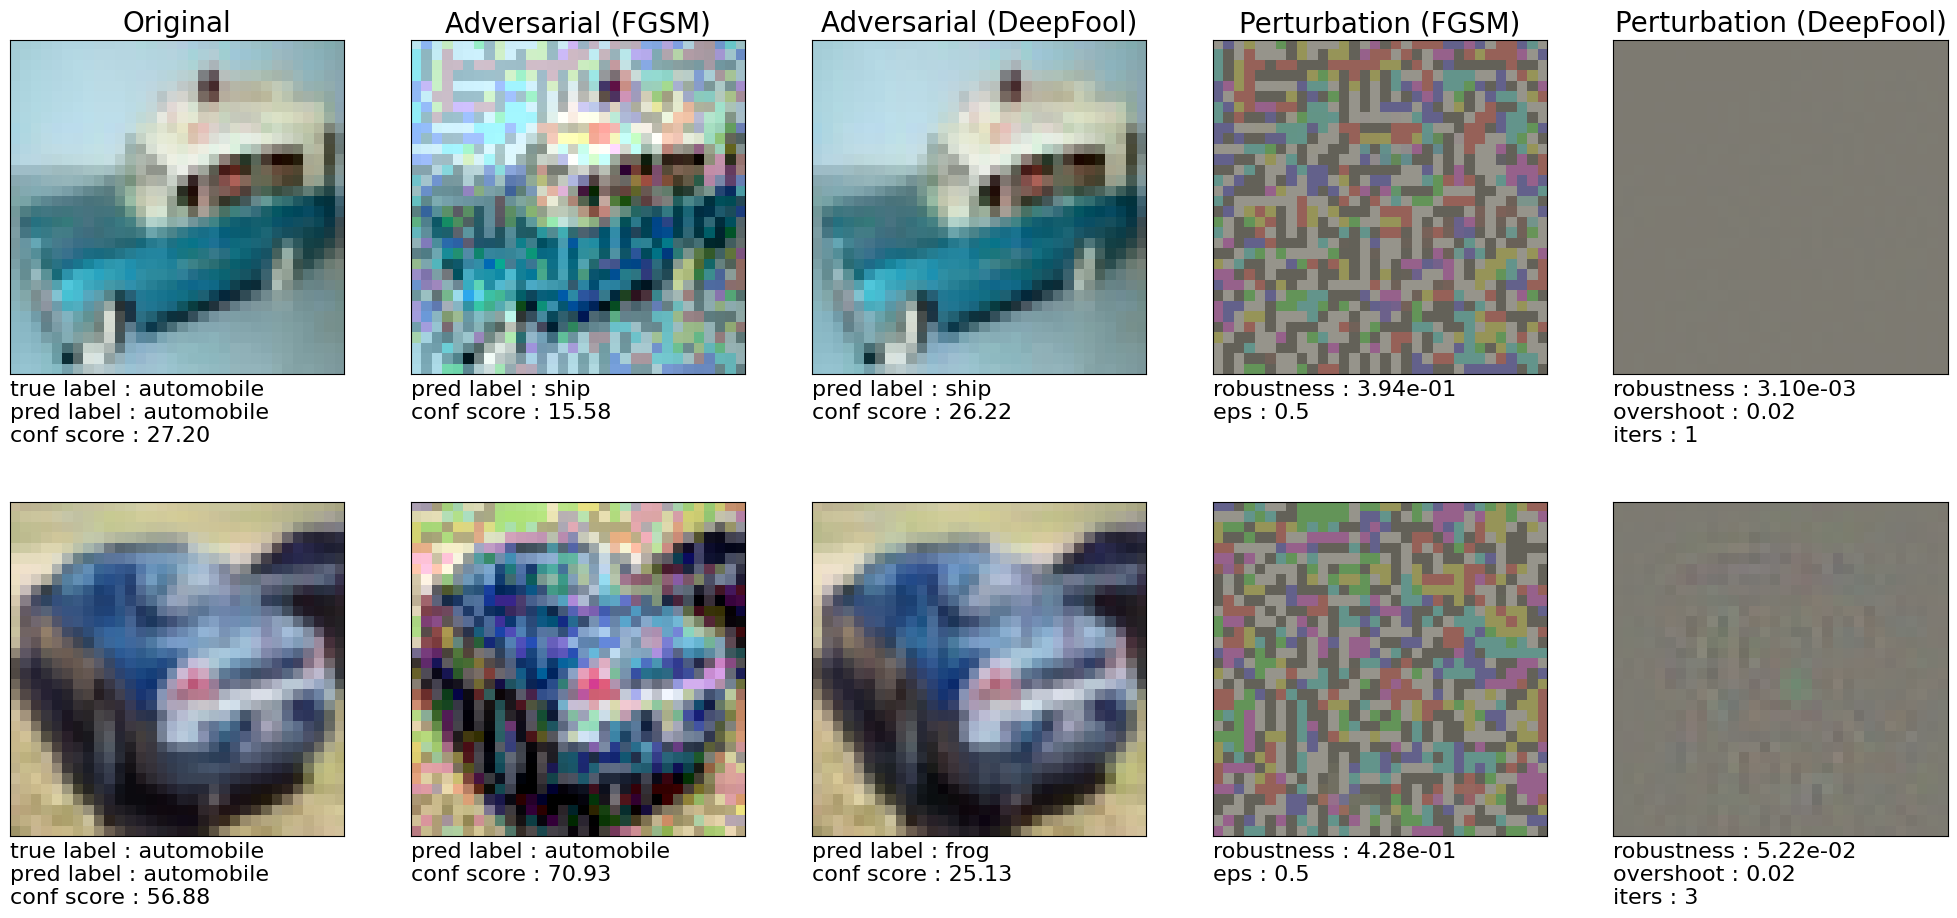

In [ ]:
fgsm_eps = 0.5
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### LeNet Model

<ipython-input-42-9ebd650e1f74>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

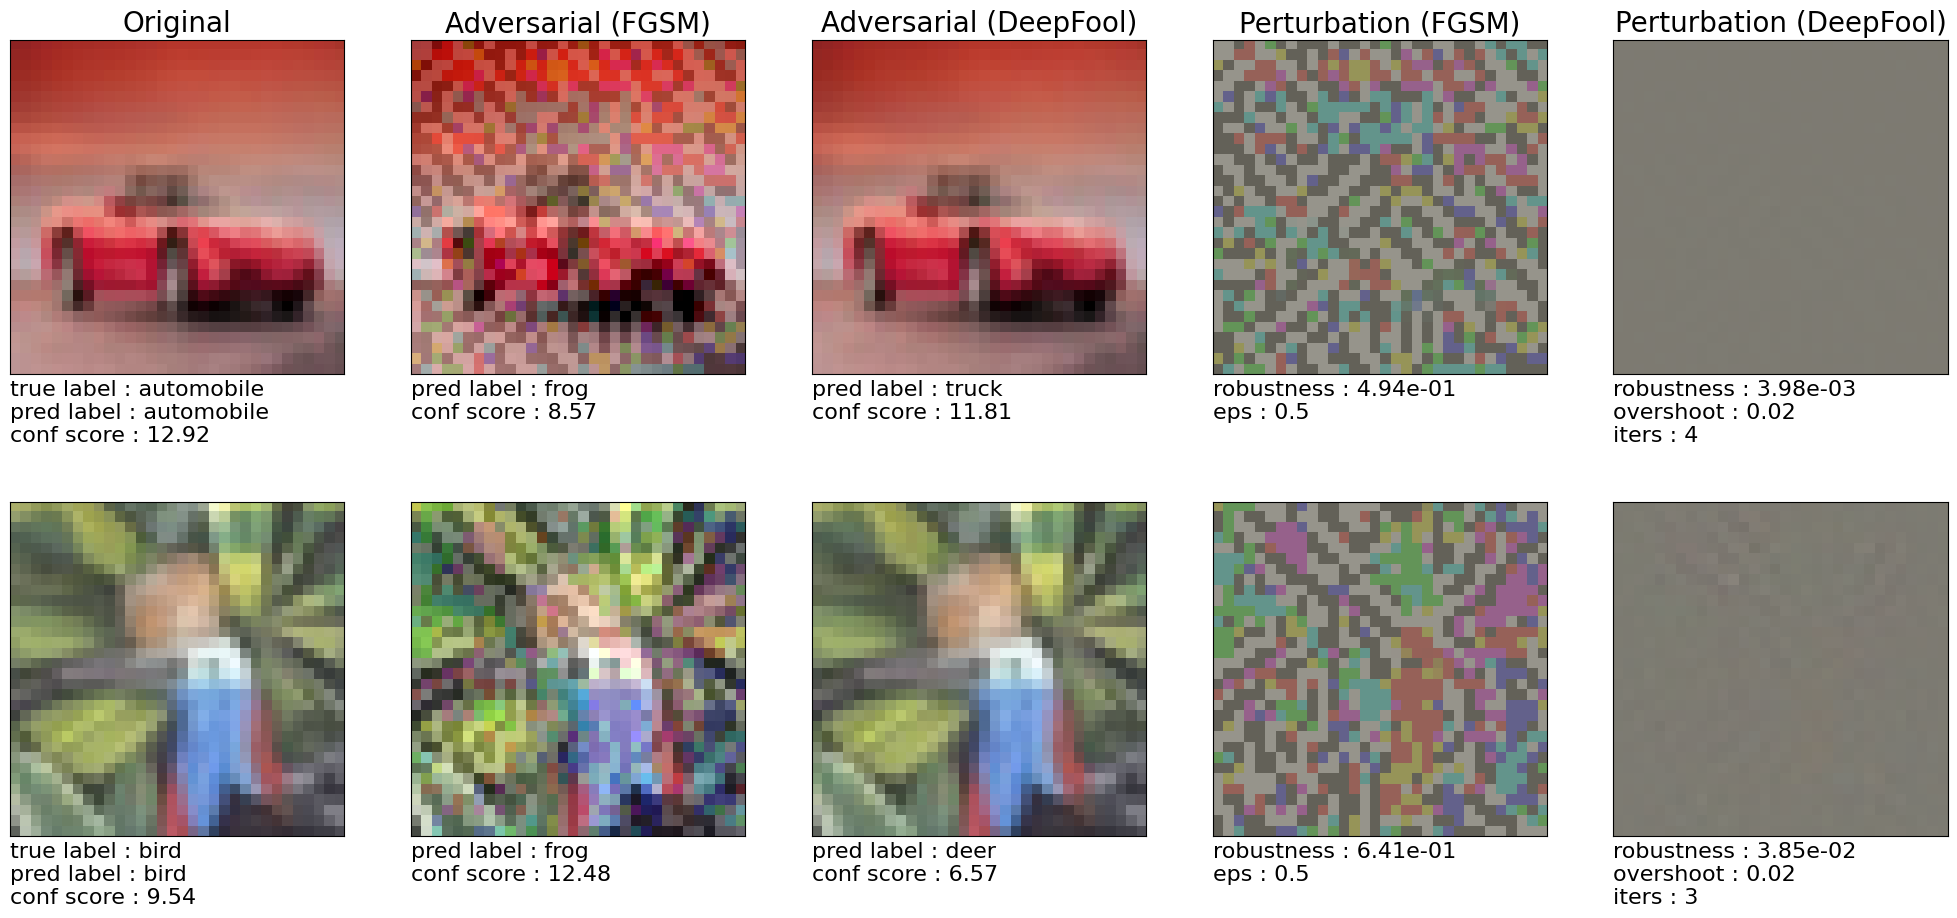

In [ ]:
fgsm_eps = 0.5
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

# 0,9

## CIFAR-10 Adversarial Evaluation 0.02

### Network-In-Network Model

In [ ]:
fgsm_eps = 0.9
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

evaluate_attack('cifar_nin_fgsm_9.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool_9.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-43-49e4faf7019b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 84.62%
FGSM Robustness : 7.79e-01
FGSM Time (All Images) : 1.47 s
FGSM Time (Per Image) : 146.82 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 198.71 s
DeepFool Time (Per Image) : 19.87 ms


### LeNet Model

In [ ]:
fgsm_eps = 0.9
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

evaluate_attack('cifar_lenet_fgsm_9.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool_9.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-44-e67b0a399089>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 92.04%
FGSM Robustness : 7.80e-01
FGSM Time (All Images) : 1.26 s
FGSM Time (Per Image) : 125.80 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 87.80%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 107.03 s
DeepFool Time (Per Image) : 10.70 ms


## Display Adversarial Examples

### MNIST

#### LeNet Model

<ipython-input-45-e93c00e25c87>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

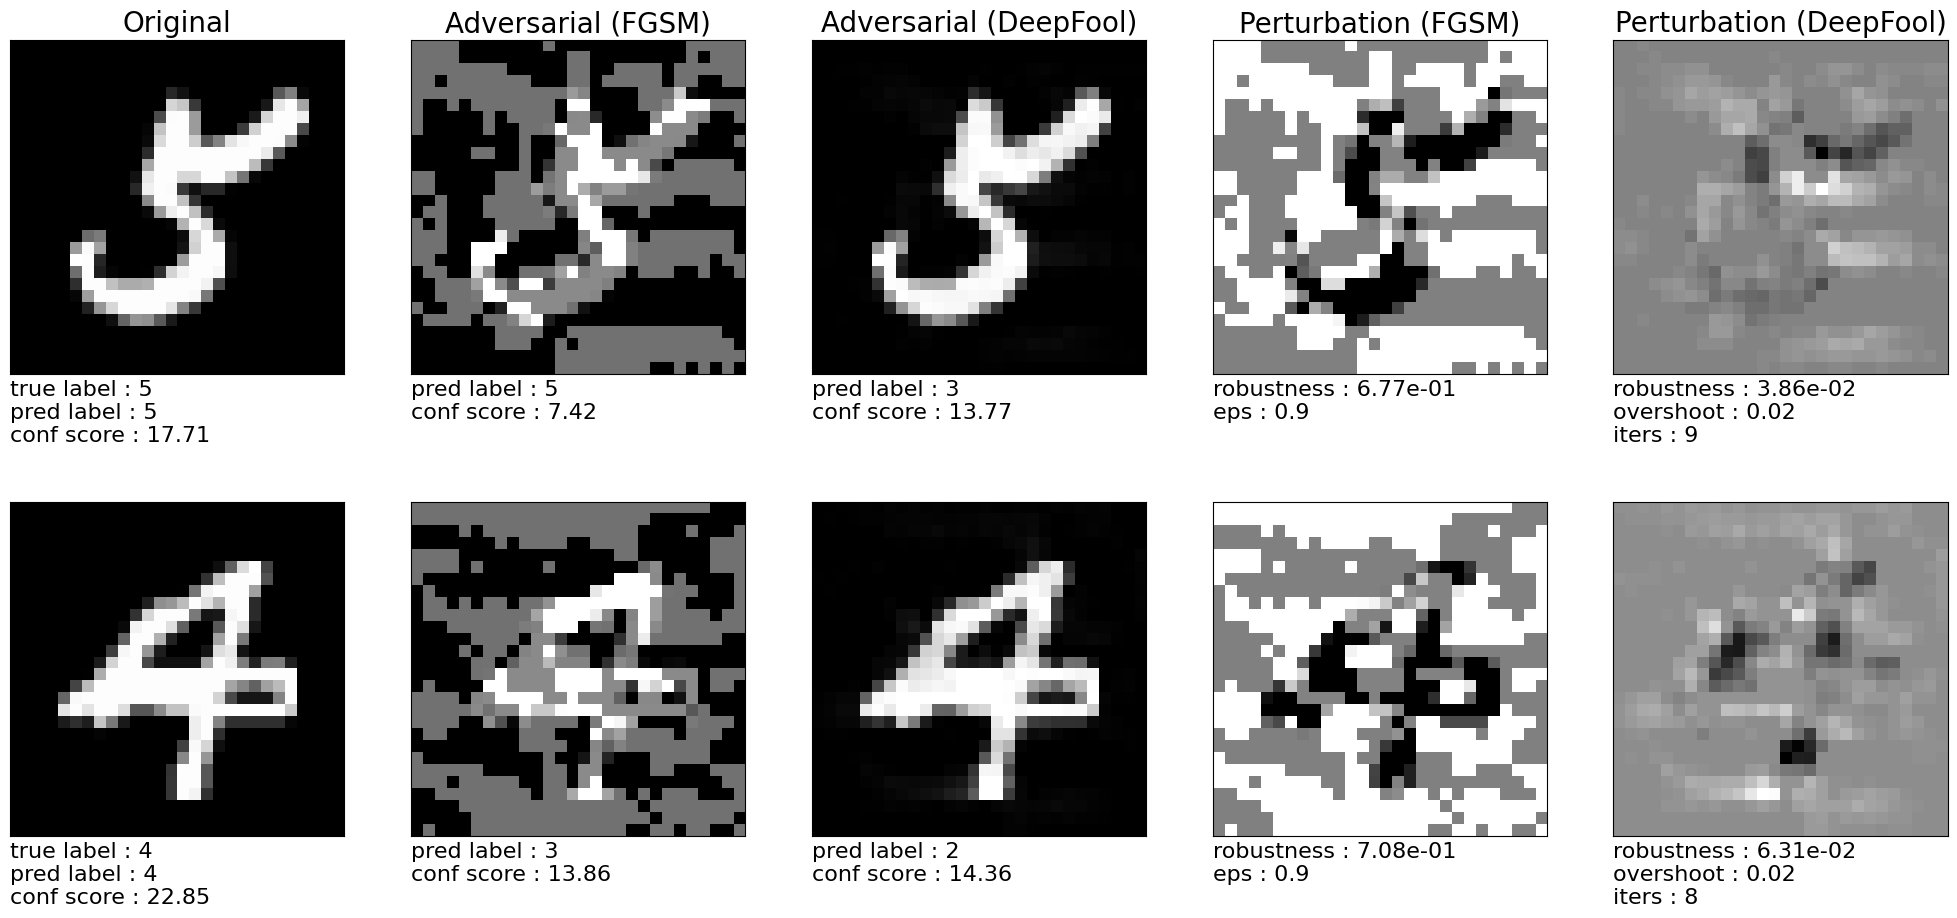

In [ ]:
fgsm_eps = 0.9
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### FC Model

<ipython-input-46-f8a3b81ce82b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

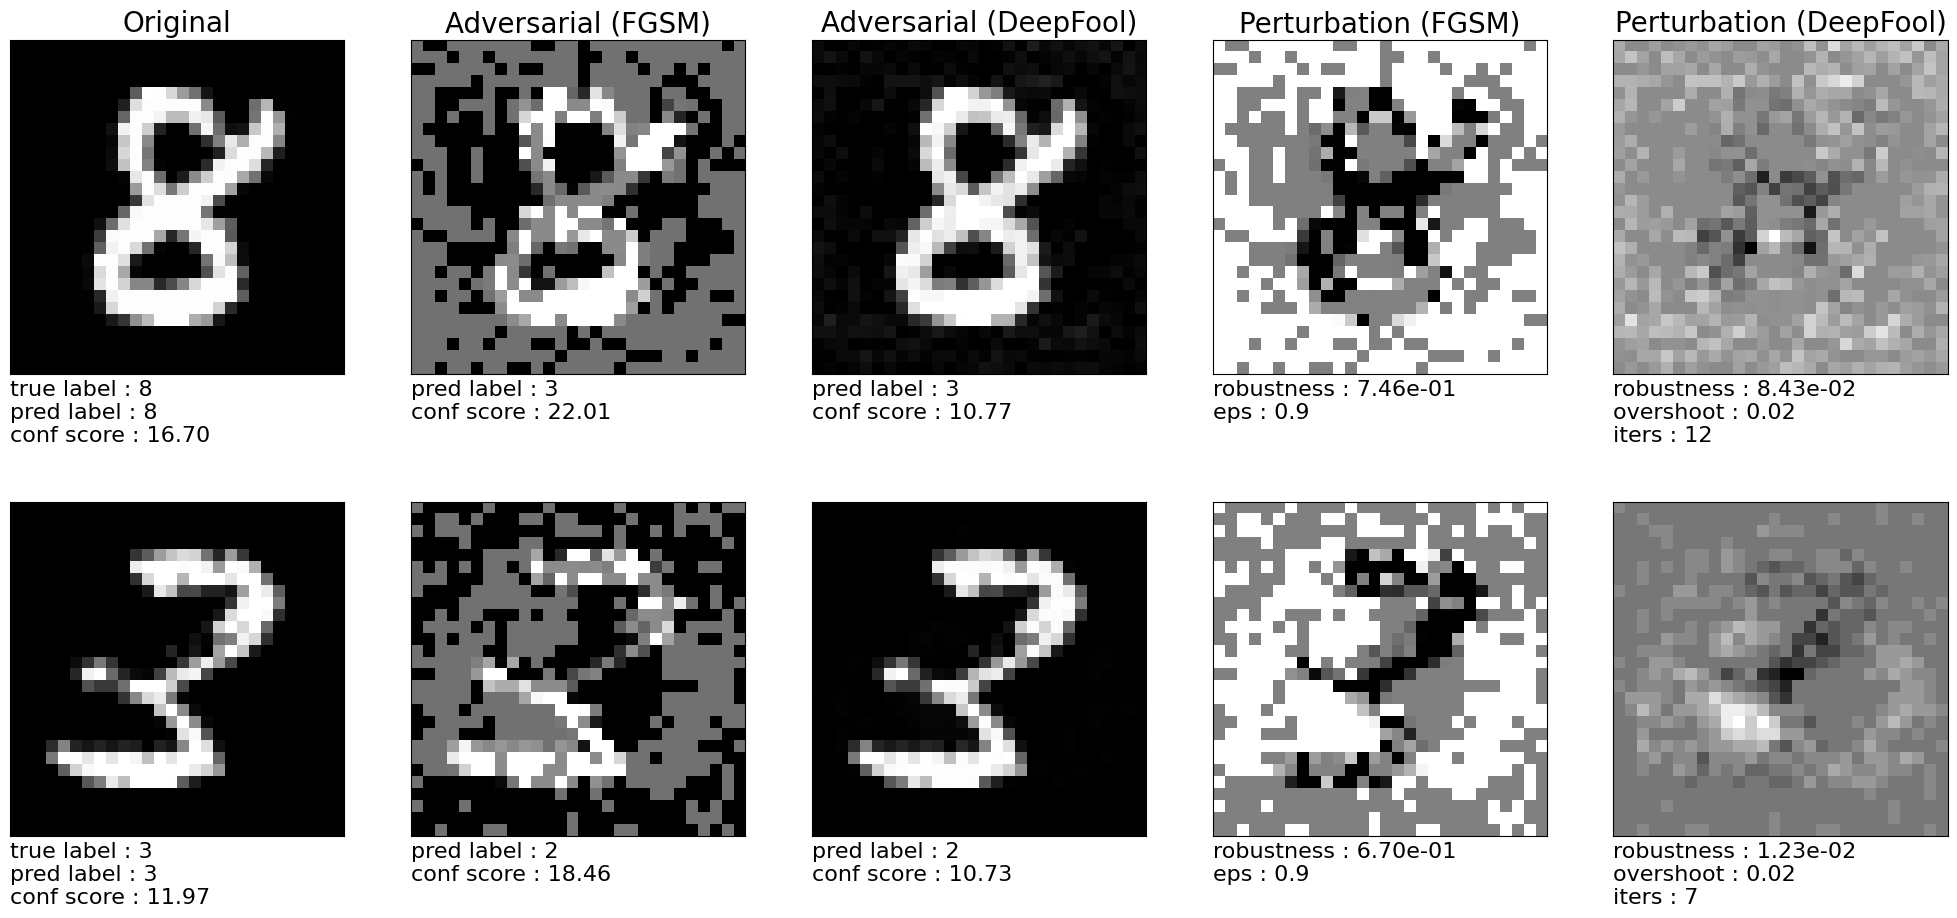

In [ ]:
fgsm_eps = 0.9
model = FC_500_150().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### CIFAR-10

#### Network-In-Network Model

<ipython-input-47-35ad7a30589e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

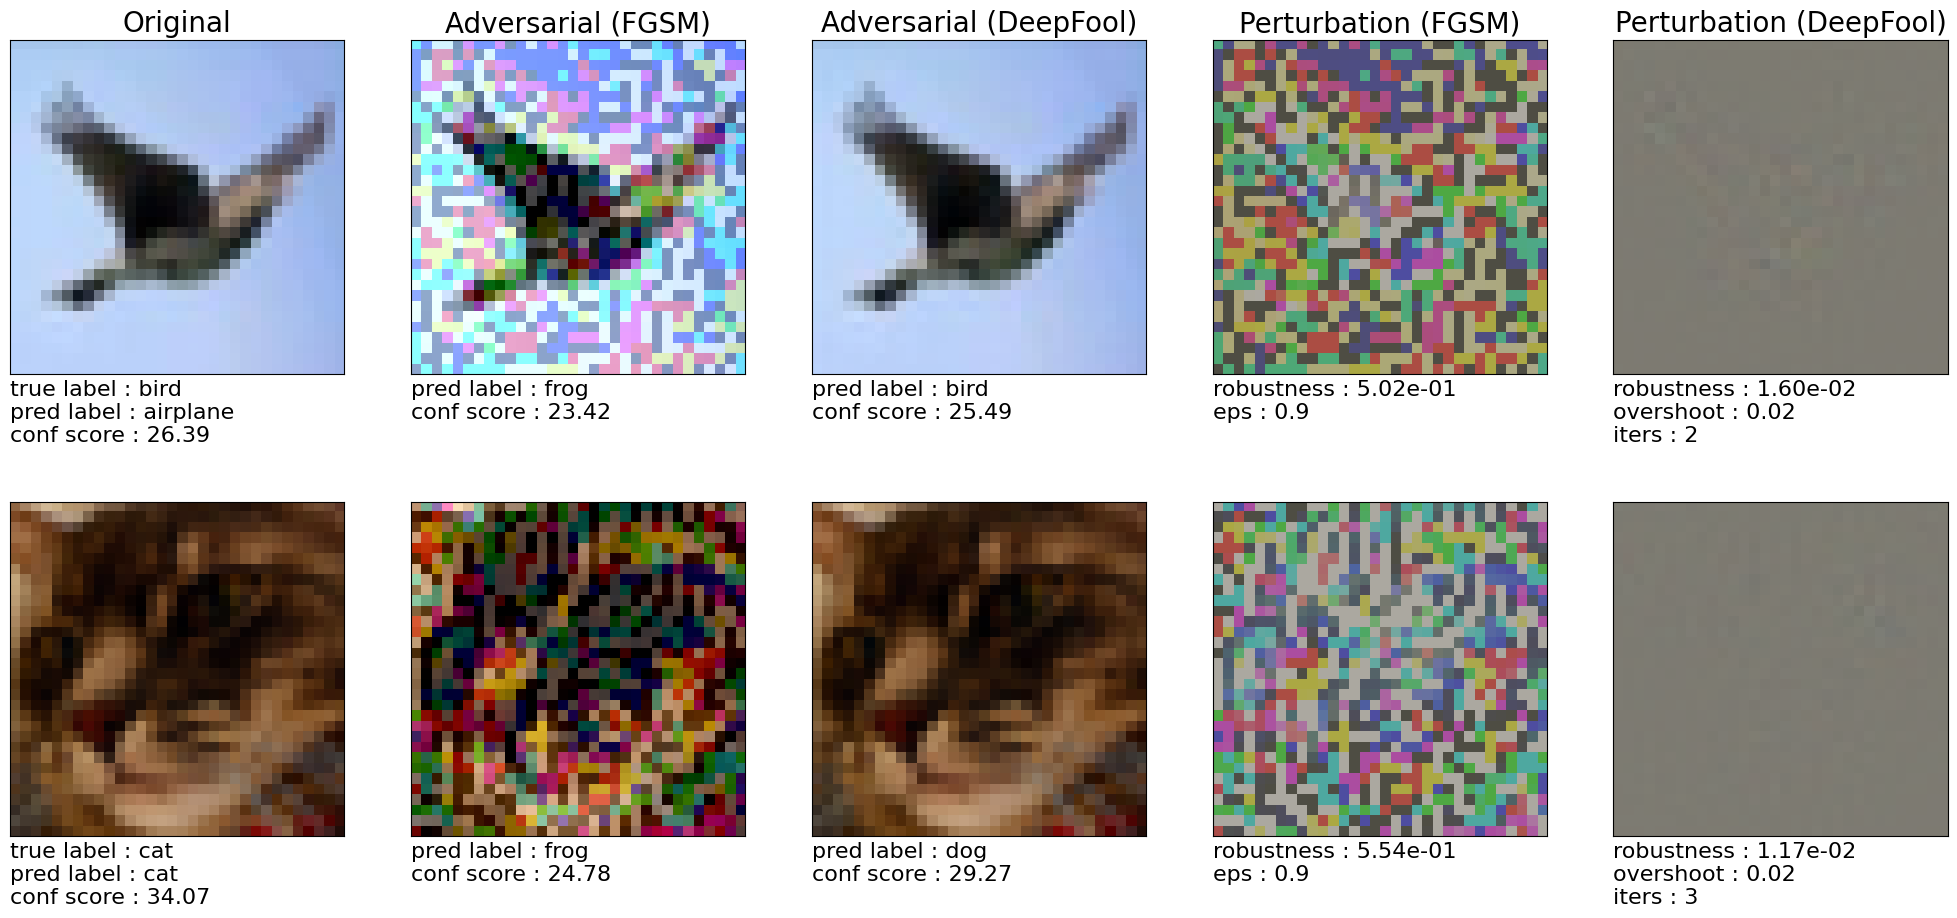

In [ ]:
fgsm_eps = 0.9
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### LeNet Model

<ipython-input-48-2514dac11051>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

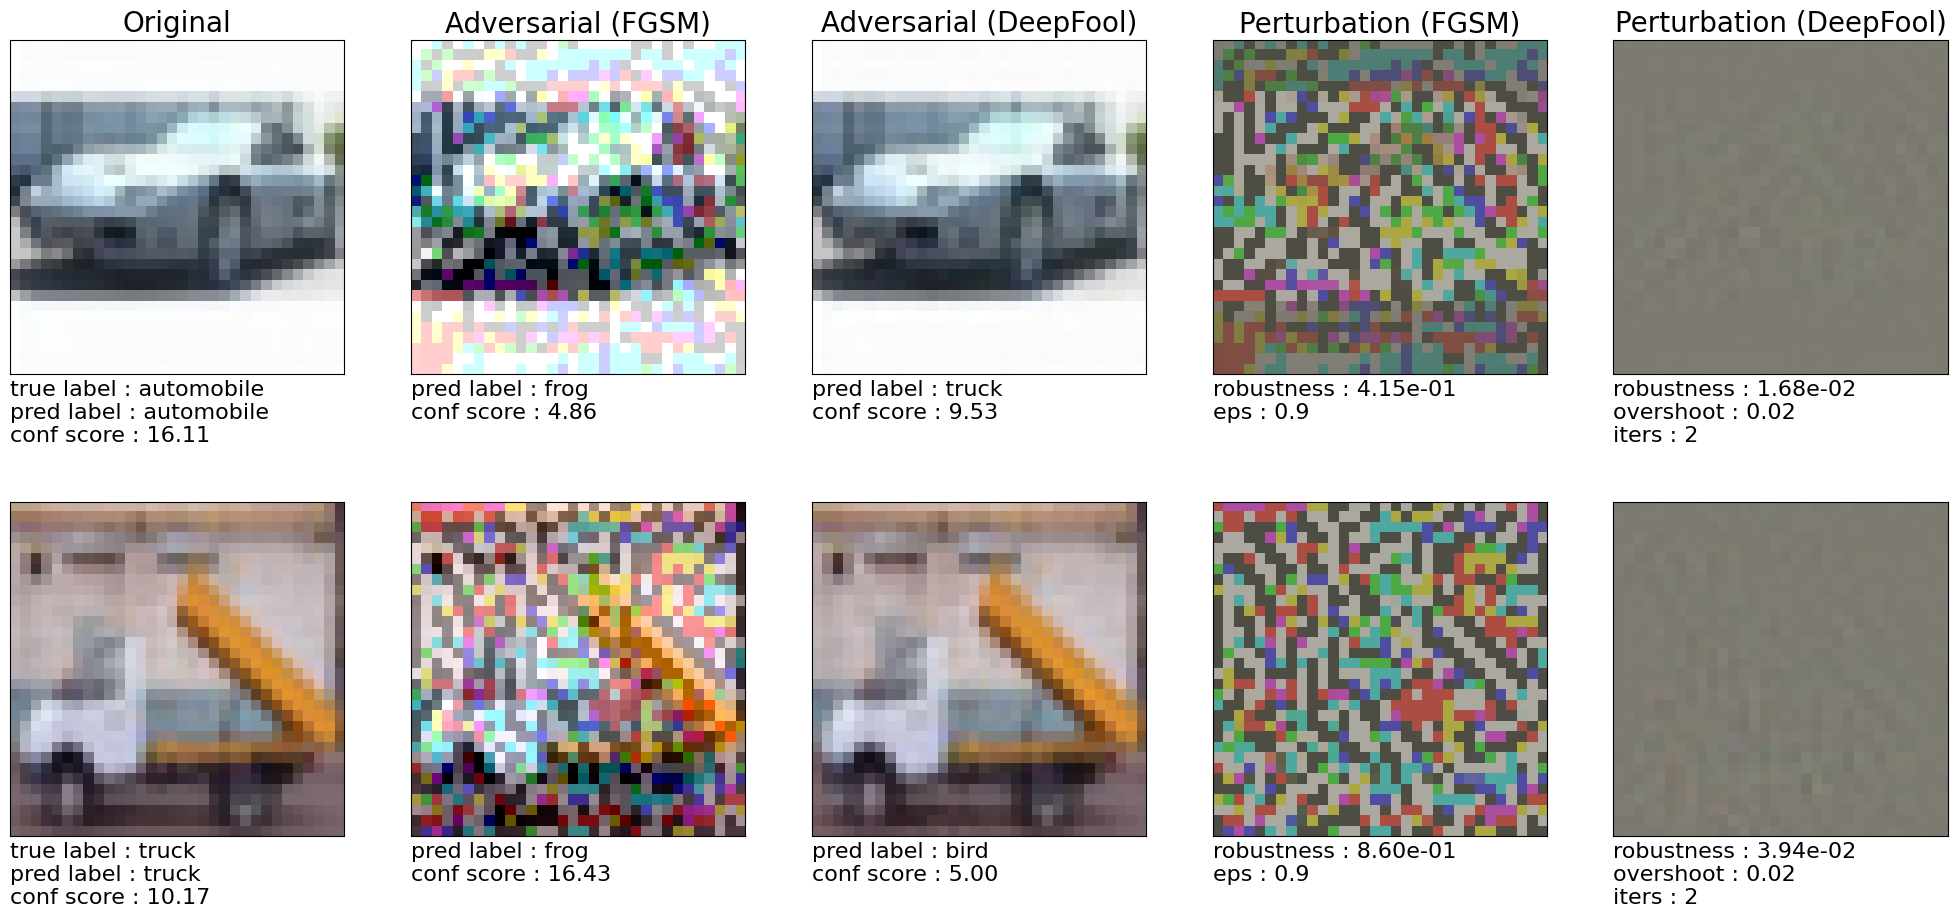

In [ ]:
fgsm_eps = 0.9
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

# 10

## CIFAR-10 Adversarial Evaluation 0.02

### Network-In-Network Model

In [ ]:
fgsm_eps = 10
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

evaluate_attack('cifar_nin_fgsm_100.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool_100.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-49-1f59396de20a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 87.50%
FGSM Robustness : 2.46e+00
FGSM Time (All Images) : 1.13 s
FGSM Time (Per Image) : 113.38 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 198.82 s
DeepFool Time (Per Image) : 19.88 ms


### LeNet Model

In [ ]:
fgsm_eps = 10
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

evaluate_attack('cifar_lenet_fgsm_100.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool_100.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-50-a53e4d04c988>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 89.90%
FGSM Robustness : 2.47e+00
FGSM Time (All Images) : 1.83 s
FGSM Time (Per Image) : 183.07 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DeepFool Batches Complete : (157 / 157)
DeepFool Test Error : 87.80%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 106.16 s
DeepFool Time (Per Image) : 10.62 ms


## Display Adversarial Examples

### MNIST

#### LeNet Model

<ipython-input-51-bd025390c607>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

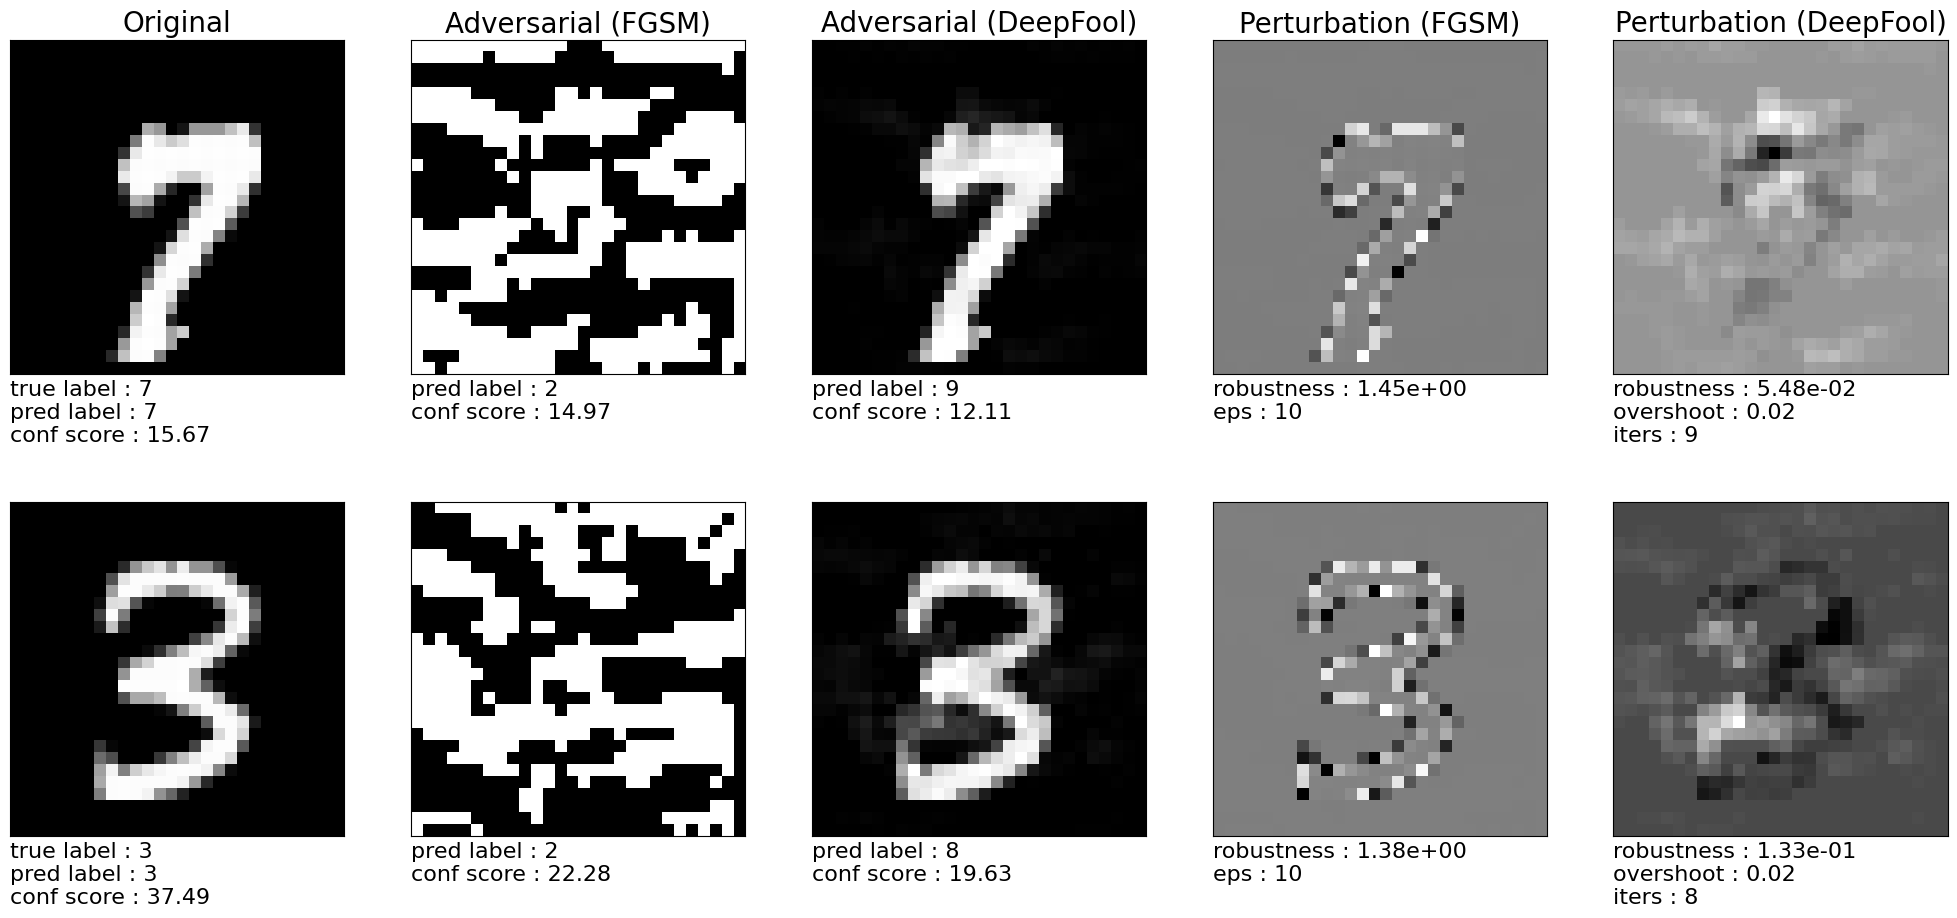

In [ ]:
fgsm_eps = 10
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### FC Model

<ipython-input-52-ab3a8f58be9f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

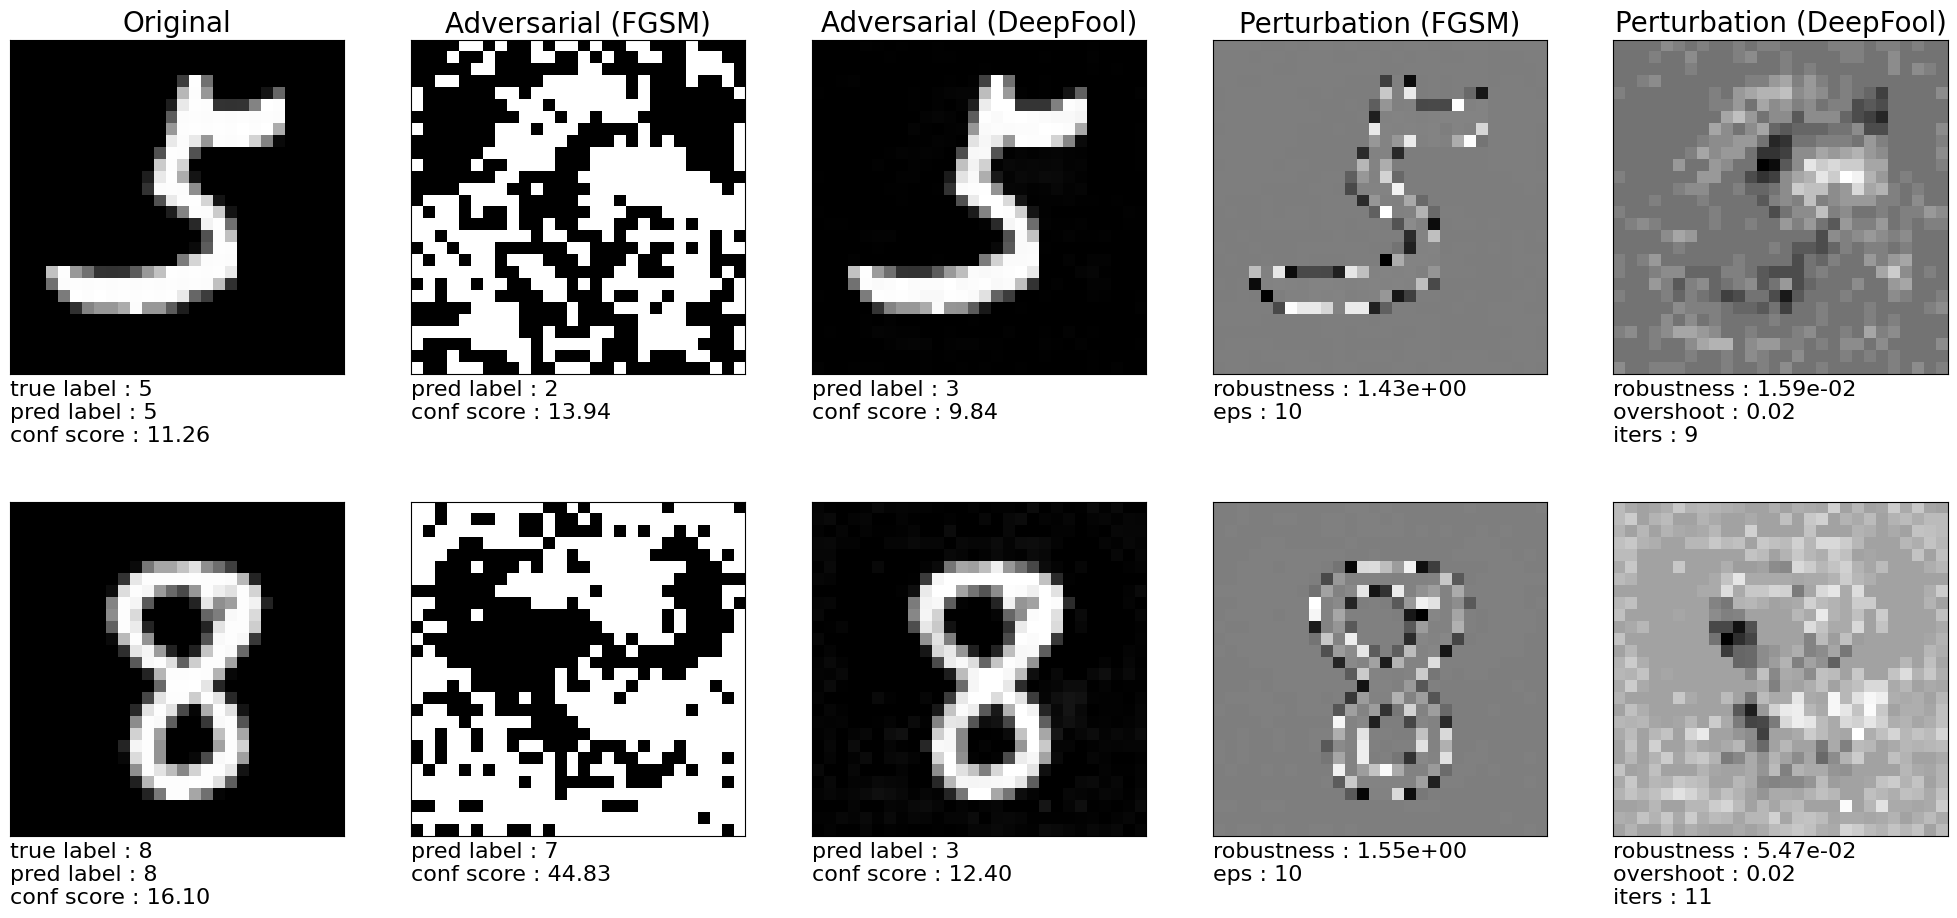

In [ ]:
fgsm_eps = 10
model = FC_500_150().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### CIFAR-10

#### Network-In-Network Model

<ipython-input-53-b02318d1a0f6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

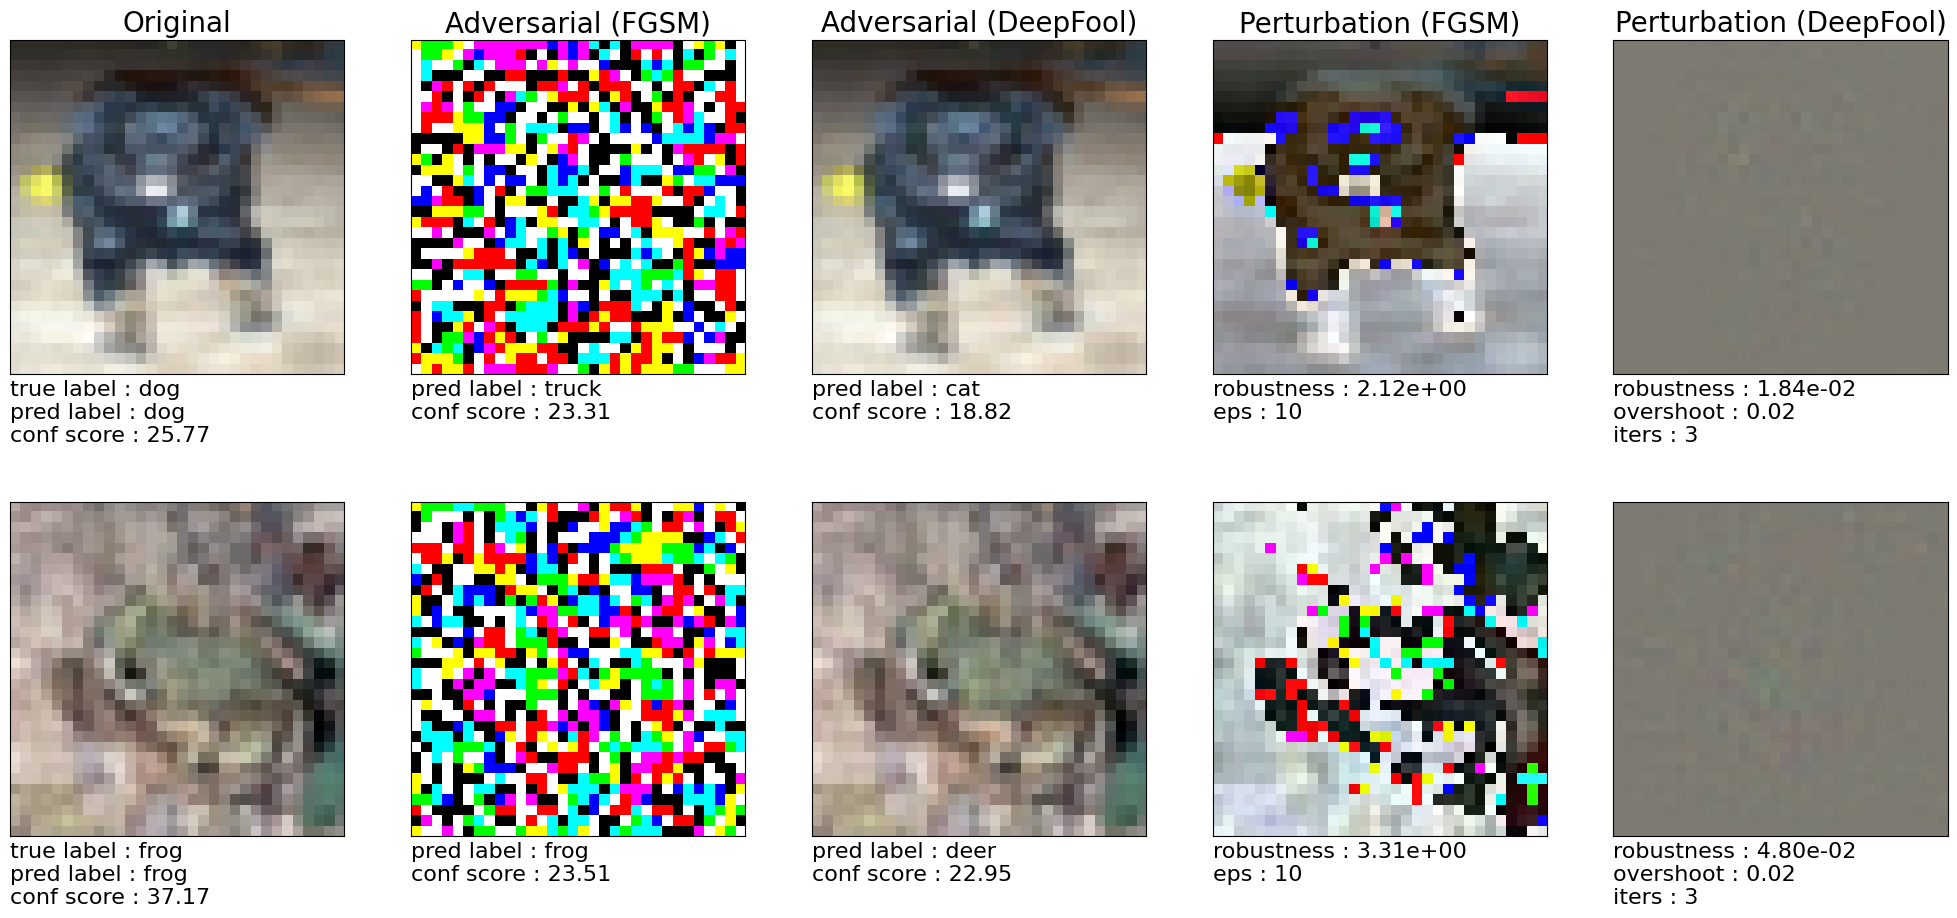

In [ ]:
fgsm_eps = 10
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### LeNet Model

<ipython-input-54-e7d0563af124>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weigh

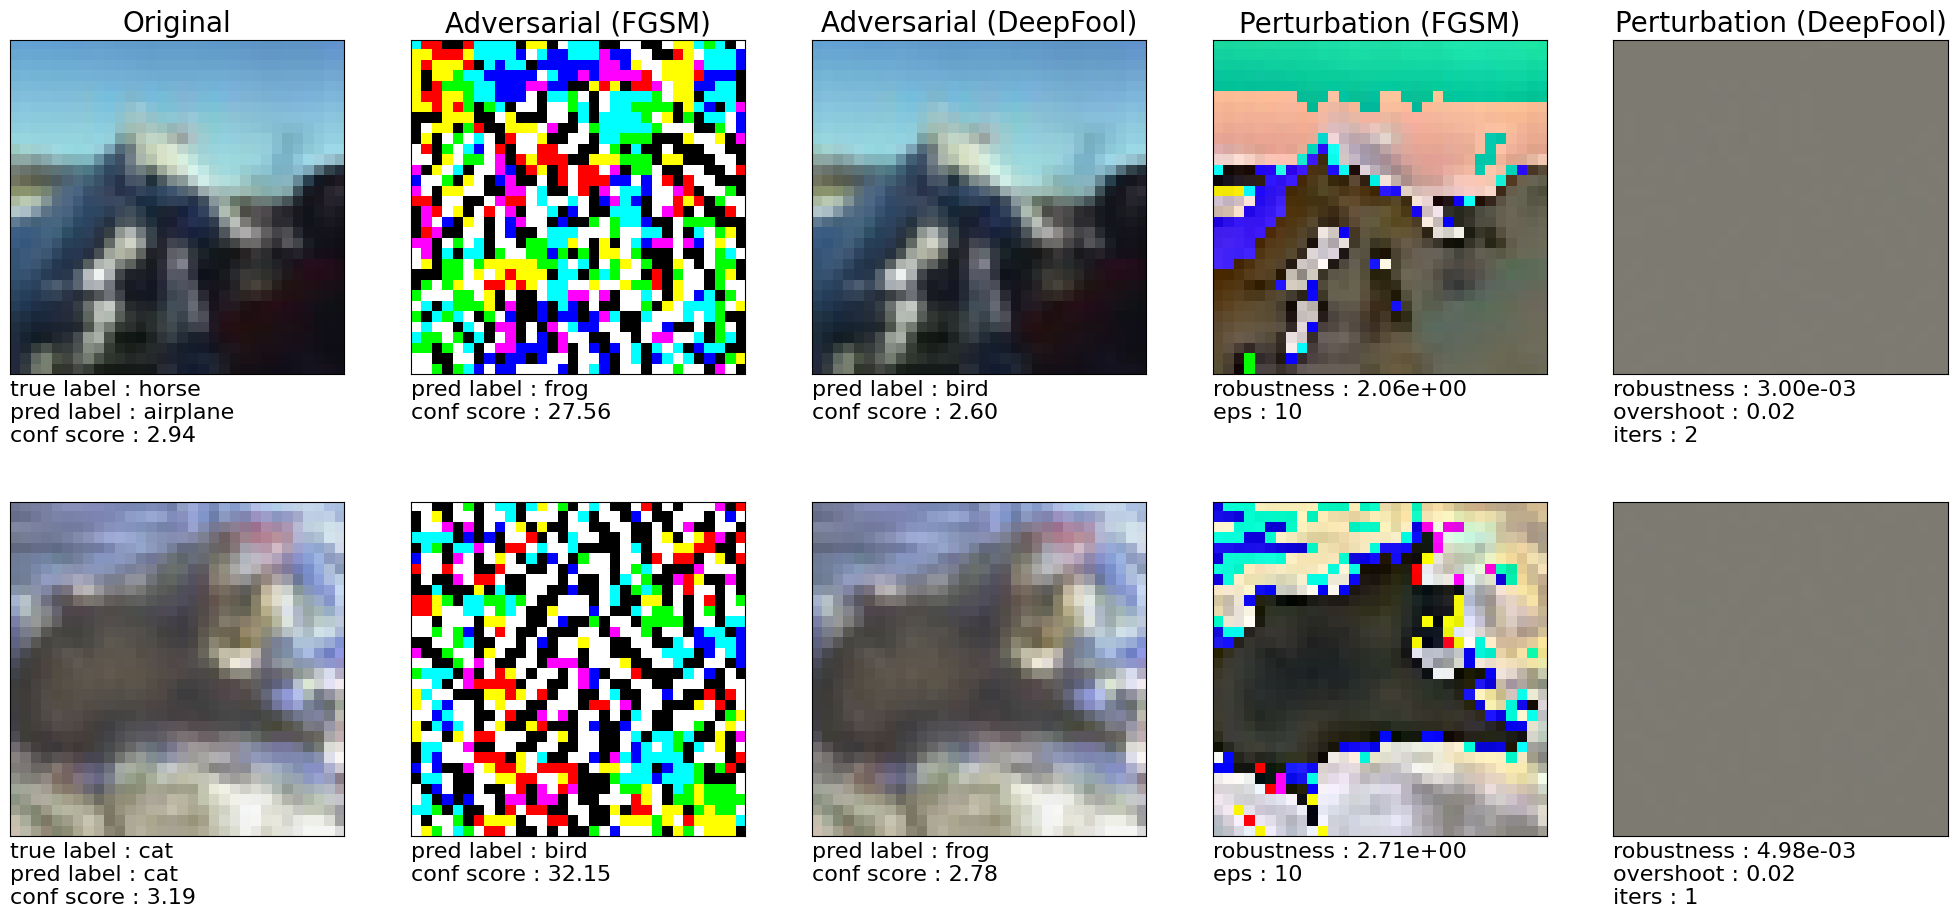

In [ ]:
fgsm_eps = 10
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/EEL6812_DeepFool_Project-main/weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()